# U.S. Medical Insurance Costs

### Project scope
The question I want to answer is: __does `sex` have an effect on `charges`?__

I will use OLS regression and include control variables (`age`, `bmi`, `children`, `smoker`, `region`, and interaction effect of `sex * children`) to confirm that a potential "gender" effect isn't actually explained by these other variables, including a mother effect (i.e. . If I stumble upon any interesting interactions I didn't expect, I will include those as well.

To do this, I will first clean and transform the data so that booleans (`smoker`, `sex`) are represented by integers (`0` = no/male; `1` = yes/female), and that the `region` variable is split into dummies (one for each region; all but one will be included in the OLS regression).

### Step 1: cleaning data and creating dataframe

##### Code

In [141]:
# Import modules
import csv
from statsmodels.regression.linear_model import OLS as ols
from statsmodels.tools import tools as st_tools
from statsmodels.stats.descriptivestats import describe as st_desc_stats
import pandas as pd
import numpy as np
import matplotlib as mpl
from sklearn import linear_model as linmod
from pandas.api.types import CategoricalDtype
from linearmodels.iv import model as lm
import statsmodels.api as sm
import statsmodels.formula.api as smf
import linearmodels.iv.model as lm
import matplotlib.pyplot as plt
import seaborn as sns

In [142]:
# Save insurance.csv as a dictionary, creating respondent IDs (1 through n) as keys
resp_ID = 0
dataset_dict = {}
with open("insurance.csv") as dataset:
    csv_reader = csv.DictReader(dataset)
    for data in csv_reader:
        resp_ID += 1
        dataset_dict[resp_ID] = data

In [143]:
# Clean variables:
for i in dataset_dict:
    
    # age
    dataset_dict[i]["age"] = int(dataset_dict[i]["age"])
    
    # sex
    if dataset_dict[i]["sex"] == "male":
        dataset_dict[i]["sex"] = 0
    if dataset_dict[i]["sex"] == "female":
        dataset_dict[i]["sex"] = 1
    
    # bmi
    dataset_dict[i]["bmi"] = float(dataset_dict[i]["bmi"])
    
    # children
    dataset_dict[i]["children"] = int(dataset_dict[i]["children"])
    
    # smoker
    if dataset_dict[i]["smoker"] == "no":
        dataset_dict[i]["smoker"] = 0
    if dataset_dict[i]["smoker"] == "yes":
        dataset_dict[i]["smoker"] = 1
    
    # regions
    dataset_dict[i]["reg_northeast"] = 0
    dataset_dict[i]["reg_southeast"] = 0
    dataset_dict[i]["reg_northwest"] = 0
    dataset_dict[i]["reg_southwest"] = 0
    if dataset_dict[i]["region"] == "northeast":
        dataset_dict[i]["reg_northeast"] = 1
    elif dataset_dict[i]["region"] == "southeast":
        dataset_dict[i]["reg_southeast"] = 1
    elif dataset_dict[i]["region"] == "northwest":
        dataset_dict[i]["reg_northwest"] = 1
    elif dataset_dict[i]["region"] == "southwest":
        dataset_dict[i]["reg_southwest"] = 1
    dataset_dict[i]["mother_opt1"] = 0
    if dataset_dict[i]["sex"] == 1:
        if dataset_dict[i]["children"] > 0:
            dataset_dict[i]["mother_opt1"] = 1
    dataset_dict[i]["mother_opt2"] = dataset_dict[i]["sex"] * dataset_dict[i]["children"]
    dataset_dict[i]["smokerbmi"] = dataset_dict[i]["smoker"] * dataset_dict[i]["bmi"]
    
    # charges
    dataset_dict[i]["charges"] = float(dataset_dict[i]["charges"])

In [144]:
# Create DataFrame and set region to categorical
df = pd.DataFrame.from_dict(dataset_dict, orient='index')
cat_type = CategoricalDtype(categories=["northeast", "northwest", "southeast", "southwest"], ordered=True)
df["region"] = df["region"].astype(cat_type)
df = st_tools.add_constant(df, prepend=True)

##### Result

In [145]:
df

,const,age,sex,bmi,children,smoker,region,charges,reg_northeast,reg_southeast,reg_northwest,reg_southwest,mother_opt1,mother_opt2,smokerbmi
1,1.0,19,1,27.900,0,1,southwest,16884.92400,0,0,0,1,0,0,27.90
2,1.0,18,0,33.770,1,0,southeast,1725.55230,0,1,0,0,0,0,0.00
3,1.0,28,0,33.000,3,0,southeast,4449.46200,0,1,0,0,0,0,0.00
4,1.0,33,0,22.705,0,0,northwest,21984.47061,0,0,1,0,0,0,0.00
5,1.0,32,0,28.880,0,0,northwest,3866.85520,0,0,1,0,0,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1334,1.0,50,0,30.970,3,0,northwest,10600.54830,0,0,1,0,0,0,0.00
1335,1.0,18,1,31.920,0,0,northeast,2205.98080,1,0,0,0,0,0,0.00
1336,1.0,18,1,36.850,0,0,southeast,1629.83350,0,1,0,0,0,0,0.00
1337,1.0,21,1,25.800,0,0,southwest,2007.94500,0,0,0,1,0,0,0.00


### Step 2: descriptive statistics

##### All numeric variables

Now that I've cleaned my data, I'll take a look at some summary statistics. I wonder how the regions differ from each other, both in terms of demographics, but also w.r.t. `charges` for each region. 

In [146]:
df_sum = df[['charges', 'age', 'sex', 'bmi', 'children', 'mother_opt1', 'mother_opt2', 'smoker']]
st_desc_stats(df_sum, ["nobs", "mean", "max", "min", "mode", "median", "skew"])

,charges,age,sex,bmi,children,mother_opt1,mother_opt2,smoker
nobs,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,13270.422265,39.207025,0.494768,30.663397,1.094918,0.278774,0.531390,0.204783
max,63770.428010,64.000000,1.000000,53.130000,5.000000,1.000000,5.000000,1.000000
min,1121.873900,18.000000,0.000000,15.960000,0.000000,0.000000,0.000000,0.000000
skew,1.514180,0.055610,0.020928,0.283729,0.937328,0.986742,1.956043,1.463124
mode,1639.563100,18.000000,0.000000,32.300000,0.000000,0.000000,0.000000,0.000000
mode_freq,0.001495,0.051570,0.505232,0.009716,0.428999,0.721226,0.721226,0.795217
median,9382.033000,39.000000,0.000000,30.400000,1.000000,0.000000,0.000000,0.000000


##### By region: southeast

In [147]:
df_sum_southeast = df_sum[df['region']=="southeast"]
df_sum_southwest = df_sum[df['region']=="southwest"]
df_sum_northeast = df_sum[df['region']=="northeast"]
df_sum_northwest = df_sum[df['region']=="northwest"]

In [148]:
st_desc_stats(df_sum_southeast, ["nobs", "mean", "max", "min", "mode", "median", "skew"])

,charges,age,sex,bmi,children,mother_opt1,mother_opt2,smoker
nobs,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000
mean,14735.411438,38.939560,0.480769,33.355989,1.049451,0.271978,0.505495,0.250000
max,63770.428010,64.000000,1.000000,53.130000,5.000000,1.000000,5.000000,1.000000
min,1121.873900,18.000000,0.000000,19.800000,0.000000,0.000000,0.000000,0.000000
skew,1.246103,0.069122,0.076980,0.219441,1.070727,1.024867,2.160728,1.154701
mode,1121.873900,18.000000,0.000000,33.330000,0.000000,0.000000,0.000000,0.000000
mode_freq,0.002747,0.101648,0.519231,0.019231,0.431319,0.728022,0.728022,0.750000
median,9294.131950,39.000000,0.000000,33.330000,1.000000,0.000000,0.000000,0.000000


##### By region: southwest

In [149]:
st_desc_stats(df_sum_southwest, ["nobs", "mean", "max", "min", "mode", "median", "skew"])

,charges,age,sex,bmi,children,mother_opt1,mother_opt2,smoker
nobs,325.000000,325.000000,325.000000,325.000000,325.000000,325.000000,325.000000,325.000000
mean,12346.937377,39.455385,0.498462,30.596615,1.141538,0.286154,0.560000,0.178462
max,52590.829390,64.000000,1.000000,47.600000,5.000000,1.000000,5.000000,1.000000
min,1241.565000,19.000000,0.000000,17.400000,0.000000,0.000000,0.000000,0.000000
skew,1.674448,0.050859,0.006154,0.159444,1.028398,0.946301,2.052217,1.679487
mode,1241.565000,19.000000,0.000000,25.800000,0.000000,0.000000,0.000000,0.000000
mode_freq,0.003077,0.095385,0.501538,0.021538,0.424615,0.713846,0.713846,0.821538
median,8798.593000,39.000000,0.000000,30.300000,1.000000,0.000000,0.000000,0.000000


##### By region: northeast

In [150]:
st_desc_stats(df_sum_northeast, ["nobs", "mean", "max", "min", "mode", "median", "skew"])

,charges,age,sex,bmi,children,mother_opt1,mother_opt2,smoker
nobs,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000
mean,13406.384516,39.268519,0.496914,29.173503,1.046296,0.274691,0.500000,0.206790
max,58571.074480,64.000000,1.000000,48.070000,5.000000,1.000000,4.000000,1.000000
min,1694.796400,18.000000,0.000000,15.960000,0.000000,0.000000,0.000000,0.000000
skew,1.486437,0.024744,0.012346,0.228357,0.958012,1.009541,1.819228,1.447937
mode,1694.796400,18.000000,0.000000,32.300000,0.000000,0.000000,0.000000,0.000000
mode_freq,0.003086,0.098765,0.503086,0.021605,0.453704,0.725309,0.725309,0.793210
median,10057.652025,39.500000,0.000000,28.880000,1.000000,0.000000,0.000000,0.000000


##### By region: northwest

In [151]:
st_desc_stats(df_sum_northwest, ["nobs", "mean", "max", "min", "mode", "median", "skew"])

,charges,age,sex,bmi,children,mother_opt1,mother_opt2,smoker
nobs,325.000000,325.000000,325.000000,325.000000,325.000000,325.000000,325.000000,325.000000
mean,12417.575374,39.196923,0.504615,29.199785,1.147692,0.283077,0.563077,0.178462
max,60021.398970,64.000000,1.000000,42.940000,5.000000,1.000000,5.000000,1.000000
min,1621.340200,19.000000,0.000000,17.385000,0.000000,0.000000,0.000000,0.000000
skew,1.674064,0.077413,-0.018462,0.044091,0.633598,0.963046,1.708185,1.679487
mode,1639.563100,19.000000,1.000000,28.310000,0.000000,0.000000,0.000000,0.000000
mode_freq,0.006154,0.104615,0.504615,0.021538,0.406154,0.716923,0.716923,0.821538
median,8965.795750,39.000000,1.000000,28.880000,1.000000,0.000000,0.000000,0.000000


At first glance, I notice that we have roughly the same number of observations for each region, which makes them easy to compare. `southeast` has a higher average `charges` than all other regions. However, this region is also notable for the four explanatory variables shown here. `southeast` has a (slightly) lower average age than the other regions, a higher proportion of males than all the other regions, and a clearly higher BMI and smoking rate than all the other regions. 

I wonder whether a regression analysis will show significant regional effects. Although there are clear differences in average `charges`, that difference may be explained by these demographic factors, rather than any factors specific to the region itself (for example, environmental effects could cause a difference associated with a region itself, independent of these other explanatory variables).

### Step 3: initial OLS regression

##### Code

In [152]:
y = df['charges']
X = df[['const', 'age', 'sex', 'bmi', 'smoker', 'children']]
model = ols(y, exog=X, missing='raise')
results = model.fit()
final_feature_names = [X.keys()[i] for i in range(len(X.keys()))]

##### Result

In [153]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     798.0
Date:                Sun, 05 May 2024   Prob (F-statistic):               0.00
Time:                        19:01:03   Log-Likelihood:                -13551.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1332   BIC:                         2.715e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.218e+04    963.902    -12.637      0.000   -1.41e+04   -1.03e+04
age          257.7350     11.904     21.651      0.000     234.383     281.087
sex          128.6399    333.361      0.386      0.700    -525.329     782.609
bmi          322.3642     27.419     11.757      0.000     268.576     376.153
smoker      2.382e+04    412.523     57.750      0.000     2.3e+04    2.46e+04
children     474.4111    137.856      3.441      0.001     203.973     744.849
==============================================================================
Omnibus:                      301.103   Durbin-Watson:                   2.087
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              720.380
Skew:                           1.214   Prob(JB):                    3.73e-157
Kurtosis:                       5.650   Cond. No.                         299.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Step 4: verify OLS assumptions
Not so fast! I have to check whether OLS is appropriate for the data I have. I will check for the OLS assumptions, then improve and/or expand my model, and then check for OLS assumptions again for the final model in step 8.

#### OLS Assumption 1: The regression model is linear in the coefficients and the error term
I will first use scatter plots to visually inspect the linearity of the relationship between the dependent variable and each independent variable. I will then use a function that first calculates the residuals, and then creates a scatter plot of actual vs. predicted values. If I see a relatively even spread around the diagonal line, I will consider this assumption verified.

##### Scatter plot: age

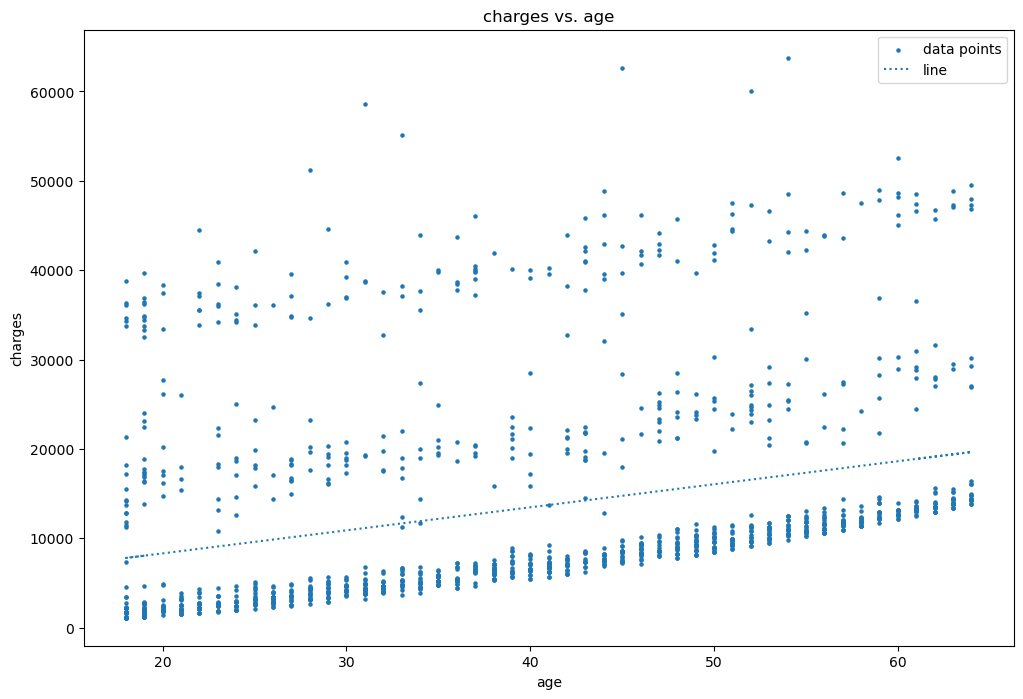

In [154]:
# Fit a linear regression model
coefficients = np.polyfit(X['age'], y, 1)
trendline = np.poly1d(coefficients)

# Scatter plot
plt.rcParams["figure.figsize"] = (12, 8)
plt.scatter(X['age'], y, label="data points", s=5)
plt.plot(X['age'], trendline(X['age']), linestyle=':', label="line")
plt.xlabel("age")
plt.ylabel("charges")
plt.title("charges vs. age")
plt.legend()

plt.show()

Age is clearly linear, but I do notice that there are essentially three clear linear lines in the scatter plot. I have a hunch that this must be because of other factors that have a significant effect on a person's healthcare costs, such as smoking, or having children. All three have a similar slope, however, so age is positively correlated with charges in any case. Let's take a closer look at these other factors, starting with smokers.

###### smokers vs. non-smokers

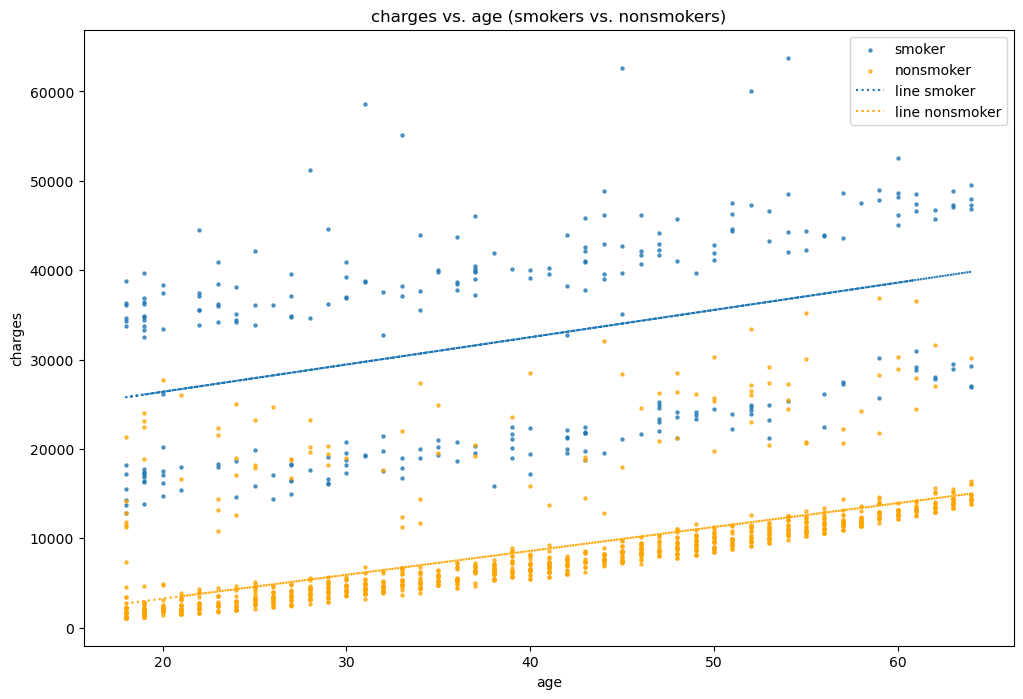

In [155]:
import matplotlib.pyplot as plt

# Separate data for smoker and nonsmoker
smoker_data = df[df['smoker'] == 1]
nonsmoker_data = df[df['smoker'] == 0]

# Fit a linear regression model for all respondents
smoker_coefficients = np.polyfit(smoker_data['age'], smoker_data['charges'], 1)
nonsmoker_coefficients = np.polyfit(nonsmoker_data['age'], nonsmoker_data['charges'], 1)
smoker_trendline = np.poly1d(smoker_coefficients)
nonsmoker_trendline = np.poly1d(nonsmoker_coefficients)

# Scatter plot with different marker colors
plt.rcParams["figure.figsize"] = (12, 8)
plt.scatter(smoker_data['age'], smoker_data['charges'], label="smoker", alpha=0.7, s=5)
plt.scatter(nonsmoker_data['age'], nonsmoker_data['charges'], color='orange', label="nonsmoker", alpha=0.7, s=5)
plt.plot(smoker_data['age'], smoker_trendline(smoker_data['age']), linestyle=':', label="line smoker")
plt.plot(nonsmoker_data['age'], nonsmoker_trendline(nonsmoker_data['age']), color='orange', linestyle=':', label="line nonsmoker")
plt.xlabel("age")
plt.ylabel("charges")
plt.title("charges vs. age (smokers vs. nonsmokers)")
plt.legend()
plt.show()

Clearly, smoking does explain some of the reason we get these multiple lines. However, there seems to be another categorical variable that explains this difference. Sex, perhaps?

###### male vs. female

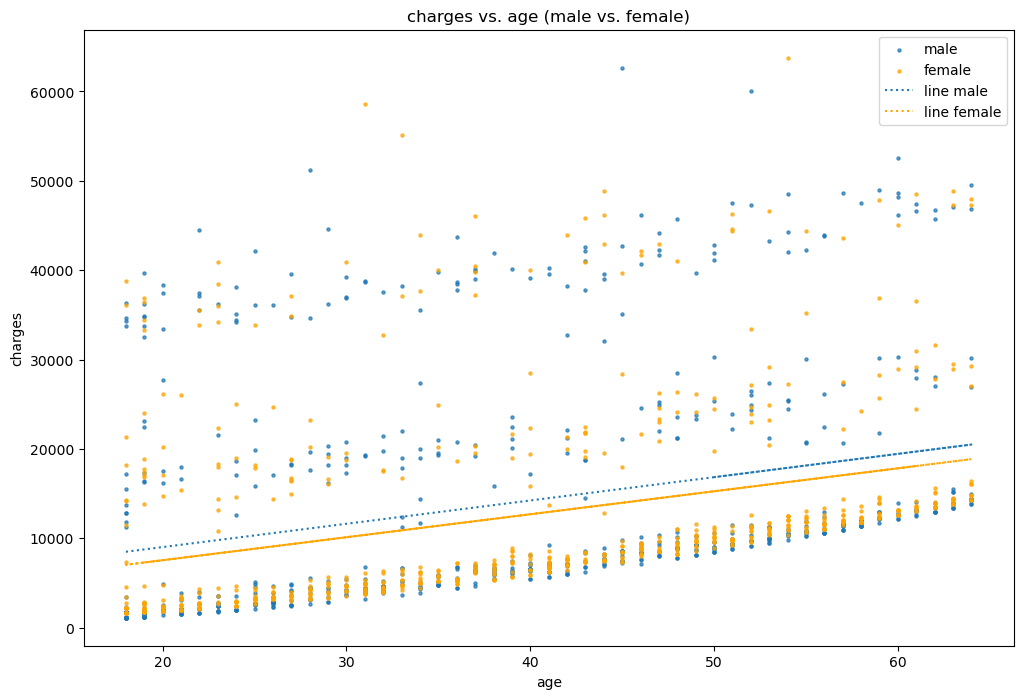

In [156]:
import matplotlib.pyplot as plt

# Separate data for male and female
male_data = df[df['sex'] == 0]
female_data = df[df['sex'] == 1]

# Fit a linear regression model for all respondents
male_coefficients = np.polyfit(male_data['age'], male_data['charges'], 1)
female_coefficients = np.polyfit(female_data['age'], female_data['charges'], 1)
male_trendline = np.poly1d(male_coefficients)
female_trendline = np.poly1d(female_coefficients)

# Scatter plot with different marker colors
plt.rcParams["figure.figsize"] = (12, 8)
plt.scatter(male_data['age'], male_data['charges'], label="male", alpha=0.7, s=5)
plt.scatter(female_data['age'], female_data['charges'], color='orange', label="female", alpha=0.7, s=5)
plt.plot(male_data['age'], male_trendline(male_data['age']), linestyle=':', label="line male")
plt.plot(female_data['age'], female_trendline(female_data['age']), color='orange', linestyle=':', label="line female")
plt.xlabel("age")
plt.ylabel("charges")
plt.title("charges vs. age (male vs. female)")
plt.legend()
plt.show()

No, sex doesn't really explain the existence of these three lines either. The difference between men and women shown here is rather minimal.

###### regions

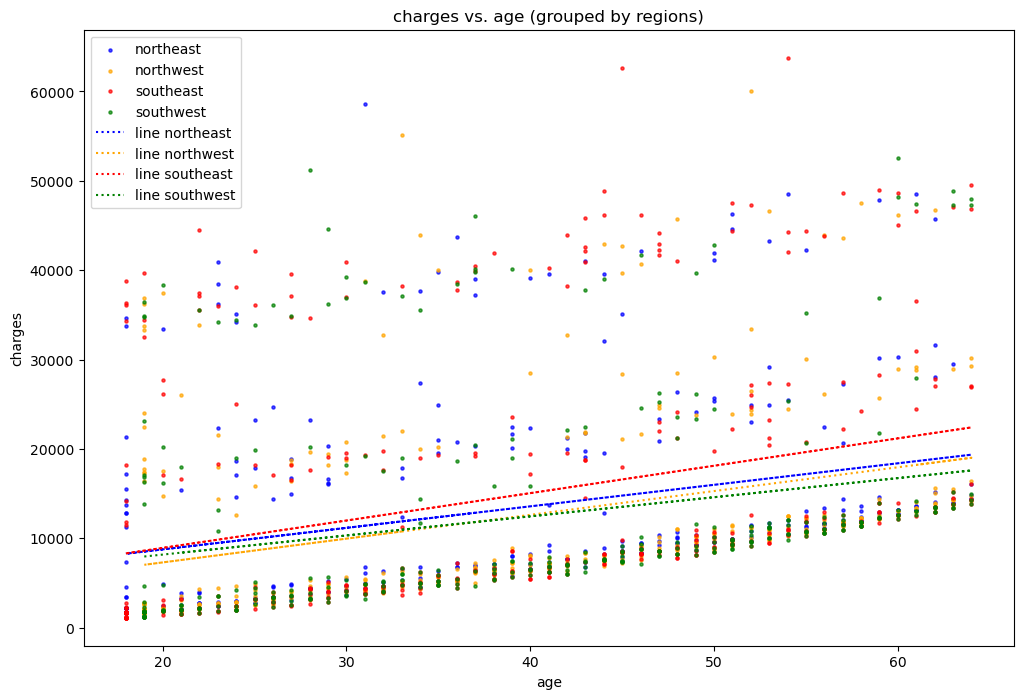

In [157]:
import matplotlib.pyplot as plt

# Separate data for smokers and non-smokers
ne_data = df[df['reg_northeast'] == 1]
nw_data = df[df['reg_northwest'] == 1]
se_data = df[df['reg_southeast'] == 1]
sw_data = df[df['reg_southwest'] == 1]

# Fit a linear regression model for all respondents
ne_coefficients = np.polyfit(ne_data['age'], ne_data['charges'], 1)
ne_trendline = np.poly1d(ne_coefficients)
nw_coefficients = np.polyfit(nw_data['age'], nw_data['charges'], 1)
nw_trendline = np.poly1d(nw_coefficients)
se_coefficients = np.polyfit(se_data['age'], se_data['charges'], 1)
se_trendline = np.poly1d(se_coefficients)
sw_coefficients = np.polyfit(sw_data['age'], sw_data['charges'], 1)
sw_trendline = np.poly1d(sw_coefficients)

# Scatter plot with different marker colors
plt.rcParams["figure.figsize"] = (12, 8)
plt.scatter(ne_data['age'], ne_data['charges'], color='blue', label="northeast", alpha=0.7, s=5)
plt.scatter(nw_data['age'], nw_data['charges'], color='orange', label="northwest", alpha=0.7, s=5)
plt.scatter(se_data['age'], se_data['charges'], color='red', label="southeast", alpha=0.7, s=5)
plt.scatter(sw_data['age'], sw_data['charges'], color='green', label="southwest", alpha=0.7, s=5)
plt.plot(ne_data['age'], ne_trendline(ne_data['age']), color='blue', linestyle=':', label="line northeast")
plt.plot(nw_data['age'], nw_trendline(nw_data['age']), color='orange', linestyle=':', label="line northwest")
plt.plot(se_data['age'], se_trendline(se_data['age']), color='red', linestyle=':', label="line southeast")
plt.plot(sw_data['age'], sw_trendline(sw_data['age']), color='green', linestyle=':', label="line southwest")
plt.xlabel("age")
plt.ylabel("charges")
plt.title("charges vs. age (grouped by regions)")
plt.legend()

plt.show()

No, the regions don't offer an explanation for these lines either.

###### children

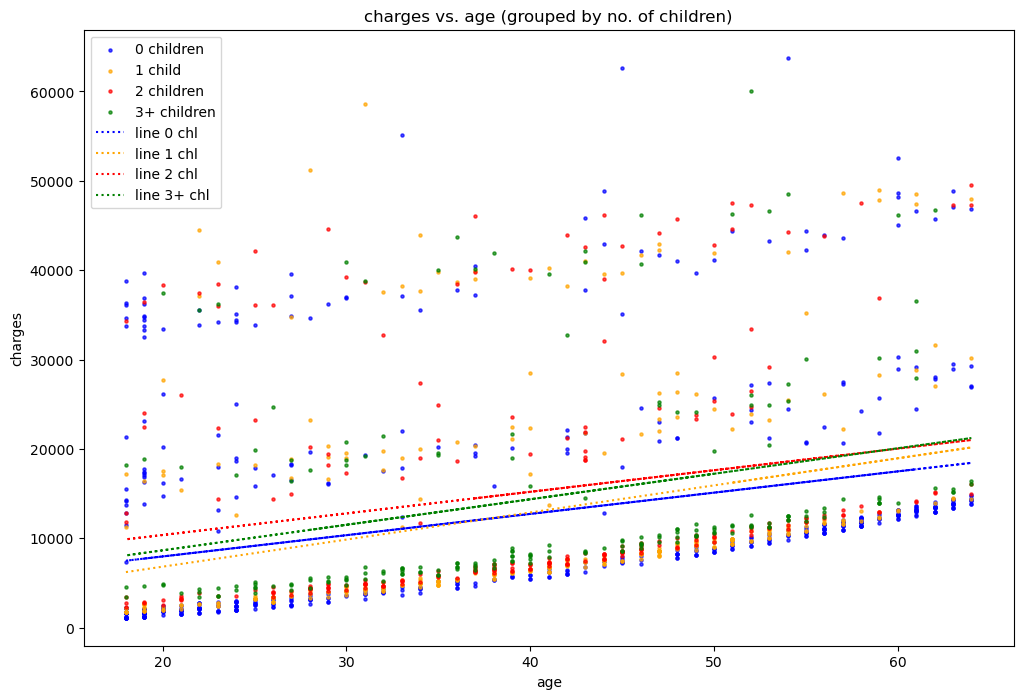

In [158]:
import matplotlib.pyplot as plt

# Separate data for smokers and non-smokers
nochl_data = df[df['children'] == 0]
onechl_data = df[df['children'] == 1]
twochl_data = df[df['children'] == 2]
threepluschl_data = df[df['children'] >= 3]

# Fit a linear regression model for all respondents
nochl_coefficients = np.polyfit(nochl_data['age'], nochl_data['charges'], 1)
nochl_trendline = np.poly1d(nochl_coefficients)
onechl_coefficients = np.polyfit(onechl_data['age'], onechl_data['charges'], 1)
onechl_trendline = np.poly1d(onechl_coefficients)
twochl_coefficients = np.polyfit(twochl_data['age'], twochl_data['charges'], 1)
twochl_trendline = np.poly1d(twochl_coefficients)
threepluschl_coefficients = np.polyfit(threepluschl_data['age'], threepluschl_data['charges'], 1)
threepluschl_trendline = np.poly1d(threepluschl_coefficients)

# Scatter plot with different marker colors
plt.rcParams["figure.figsize"] = (12, 8)
plt.scatter(nochl_data['age'], nochl_data['charges'], color='blue', label="0 children", alpha=0.7, s=5)
plt.scatter(onechl_data['age'], onechl_data['charges'], color='orange', label="1 child", alpha=0.7, s=5)
plt.scatter(twochl_data['age'], twochl_data['charges'], color='red', label="2 children", alpha=0.7, s=5)
plt.scatter(threepluschl_data['age'], threepluschl_data['charges'], color='green', label="3+ children", alpha=0.7, s=5)
plt.plot(nochl_data['age'], nochl_trendline(nochl_data['age']), color='blue', linestyle=':', label="line 0 chl")
plt.plot(onechl_data['age'], onechl_trendline(onechl_data['age']), color='orange', linestyle=':', label="line 1 chl")
plt.plot(twochl_data['age'], twochl_trendline(twochl_data['age']), color='red', linestyle=':', label="line 2 chl")
plt.plot(threepluschl_data['age'], threepluschl_trendline(threepluschl_data['age']), color='green', linestyle=':', label="line 3+ chl")
plt.xlabel("age")
plt.ylabel("charges")
plt.title("charges vs. age (grouped by no. of children)")
plt.legend()

plt.show()

Number of children also can't explain these clusters. I will have to accept these clusters without an explanation; perhaps this data is synthetic and doesn't represent the real world very well. If so, no explanation (i.e. an interaction) exists for these three clusters.

##### Scatter plot: sex

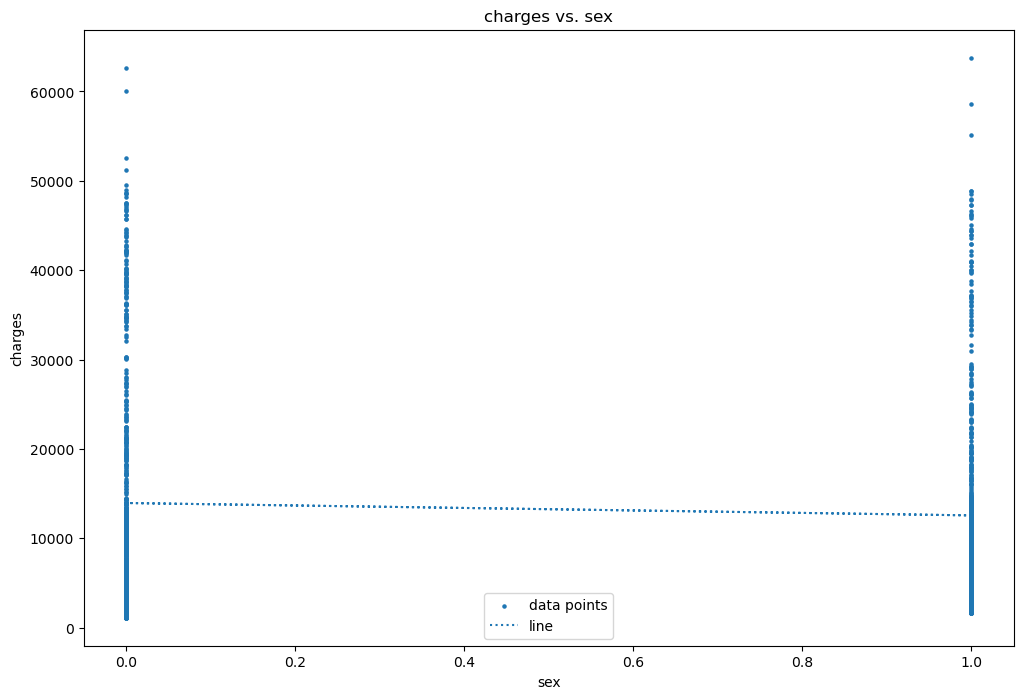

In [159]:
# Fit a linear regression model
coefficients = np.polyfit(X['sex'], y, 1)
trendline = np.poly1d(coefficients)

# Scatter plot
plt.rcParams["figure.figsize"] = (12, 8)
plt.scatter(X['sex'], y, label="data points", s=5)
plt.plot(X['sex'], trendline(X['sex']), linestyle=':', label="line")
plt.xlabel("sex")
plt.ylabel("charges")
plt.title("charges vs. sex")
plt.legend()

plt.show()

Sex is a dummy variable, and is therefore linear by default.

##### Scatter plot: bmi

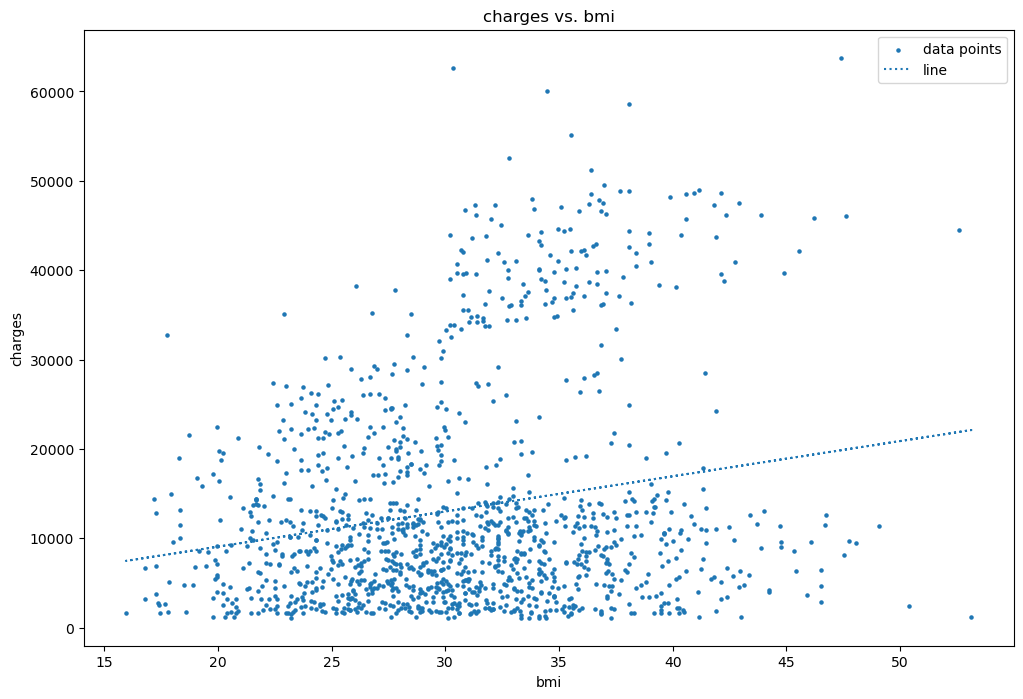

In [160]:
# Fit a linear regression model
coefficients = np.polyfit(X['bmi'], y, 1)
trendline = np.poly1d(coefficients)

# Scatter plot
plt.rcParams["figure.figsize"] = (12, 8)
plt.scatter(X['bmi'], y, label="data points", s=5)
plt.plot(X['bmi'], trendline(X['bmi']), linestyle=':', label="line")
plt.xlabel("bmi")
plt.ylabel("charges")
plt.title("charges vs. bmi")
plt.legend()

plt.show()

BMI seems somewhat linear, but not very much so. I feel like smoking may cause the two clusters I can kind of see here. Let's see!

###### smokers vs. non-smokers

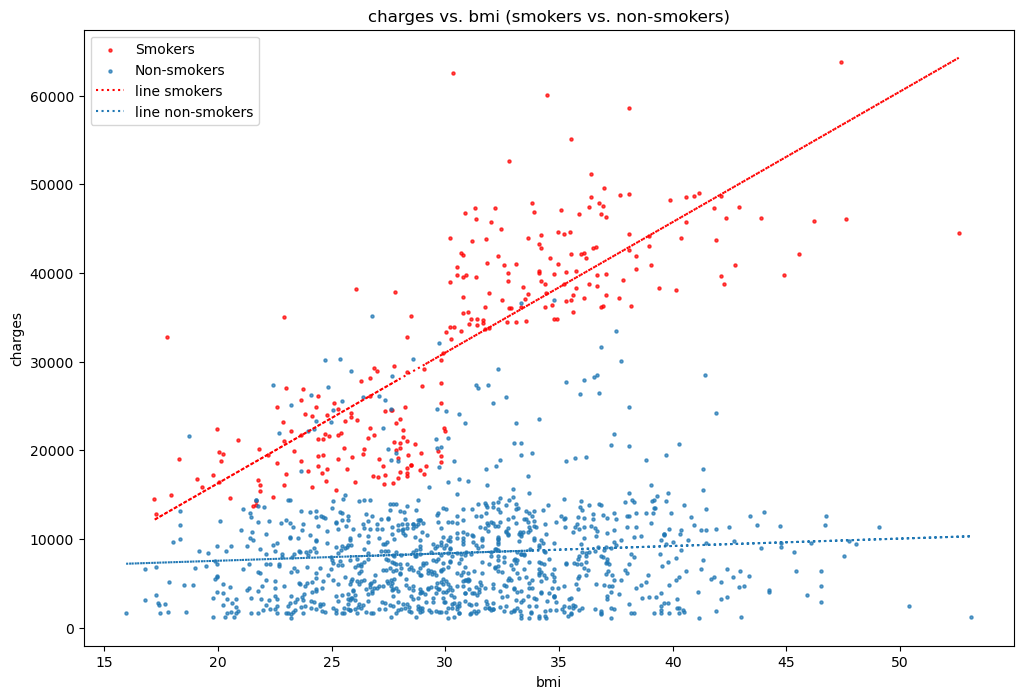

In [193]:
# Separate data for smokers and non-smokers
smoker_data = df[df['smoker'] == 1]
non_smoker_data = df[df['smoker'] == 0]

# Fit linear regression models for smokers and non-smokers
smoker_coefficients = np.polyfit(smoker_data['bmi'], smoker_data['charges'], 1)
non_smoker_coefficients = np.polyfit(non_smoker_data['bmi'], non_smoker_data['charges'], 1)

smoker_trendline = np.poly1d(smoker_coefficients)
non_smoker_trendline = np.poly1d(non_smoker_coefficients)

# Scatter plot with different marker colors and lines
plt.rcParams["figure.figsize"] = (12, 8)
plt.scatter(smoker_data['bmi'], smoker_data['charges'], color='red', label="Smokers", alpha=0.7, s=5)
plt.scatter(non_smoker_data['bmi'], non_smoker_data['charges'], label="Non-smokers", alpha=0.7, s=5)
plt.plot(smoker_data['bmi'], smoker_trendline(smoker_data['bmi']), color='red', linestyle=':', label="line smokers")
plt.plot(non_smoker_data['bmi'], non_smoker_trendline(non_smoker_data['bmi']), linestyle=':', label="line non-smokers")
plt.xlabel("bmi")
plt.ylabel("charges")
plt.title("charges vs. bmi (smokers vs. non-smokers)")
plt.legend()

plt.show()

Whether you smoke or not does indeed make a difference. When observations are split by smoking/non-smoking, the relationship is (mostly) linear for each of the two groups.

Interestingly, the relationship between bmi and charges is almost flat for non-smokers. This means that there may not be a direct relationship between bmi and charges, *except* if the person is also a smoker. For people who smoke, the relationship is more linear, and has a much steeper slope. Because of this, I will include a smoker-bmi interaction variable in the model.

##### Scatter plot: children

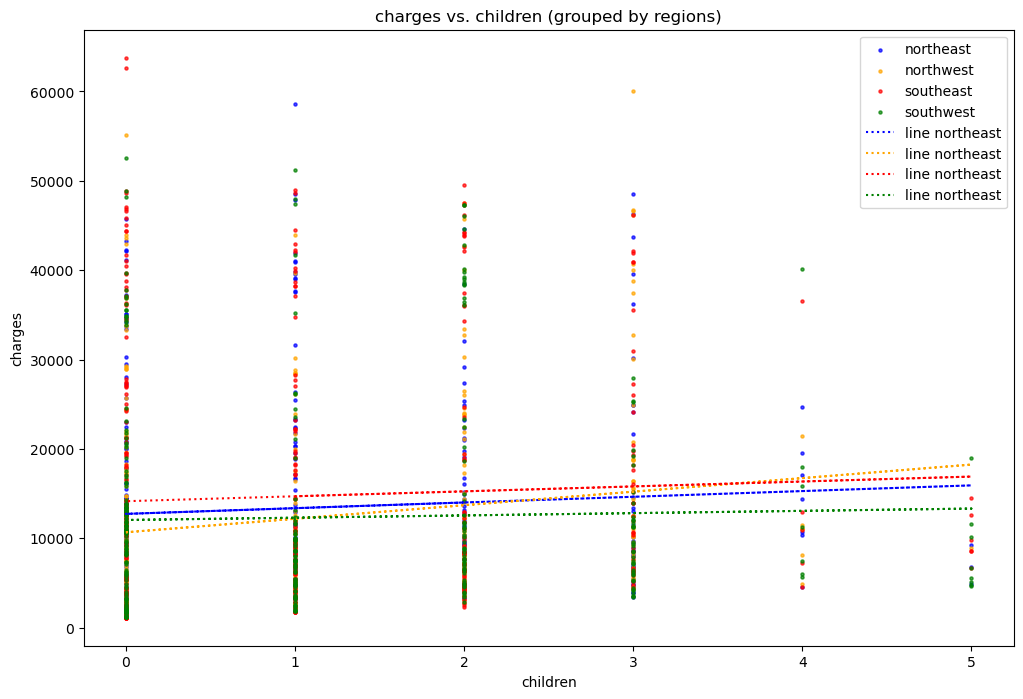

In [162]:
# Separate data for smokers and non-smokers
ne_data = df[df['reg_northeast'] == 1]
nw_data = df[df['reg_northwest'] == 1]
se_data = df[df['reg_southeast'] == 1]
sw_data = df[df['reg_southwest'] == 1]

# Fit linear regression models for smokers and non-smokers
ne_coefficients = np.polyfit(ne_data['children'], ne_data['charges'], 1)
nw_coefficients = np.polyfit(nw_data['children'], nw_data['charges'], 1)
se_coefficients = np.polyfit(se_data['children'], se_data['charges'], 1)
sw_coefficients = np.polyfit(sw_data['children'], sw_data['charges'], 1)
ne_trendline = np.poly1d(ne_coefficients)
nw_trendline = np.poly1d(nw_coefficients)
se_trendline = np.poly1d(se_coefficients)
sw_trendline = np.poly1d(sw_coefficients)

# Scatter plot with different marker colors
plt.rcParams["figure.figsize"] = (12, 8)
plt.scatter(ne_data['children'], ne_data['charges'], color='blue', label="northeast", alpha=0.7, s=5)
plt.scatter(nw_data['children'], nw_data['charges'], color='orange', label="northwest", alpha=0.7, s=5)
plt.scatter(se_data['children'], se_data['charges'], color='red', label="southeast", alpha=0.7, s=5)
plt.scatter(sw_data['children'], sw_data['charges'], color='green', label="southwest", alpha=0.7, s=5)
plt.plot(ne_data['children'], ne_trendline(ne_data['children']), color='blue', linestyle=':', label="line northeast")
plt.plot(nw_data['children'], nw_trendline(nw_data['children']), color='orange', linestyle=':', label="line northeast")
plt.plot(se_data['children'], se_trendline(se_data['children']), color='red', linestyle=':', label="line northeast")
plt.plot(sw_data['children'], sw_trendline(sw_data['children']), color='green', linestyle=':', label="line northeast")
plt.xlabel("children")
plt.ylabel("charges")
plt.title("charges vs. children (grouped by regions)")
plt.legend()

plt.show()

##### Scatter plot: smoker

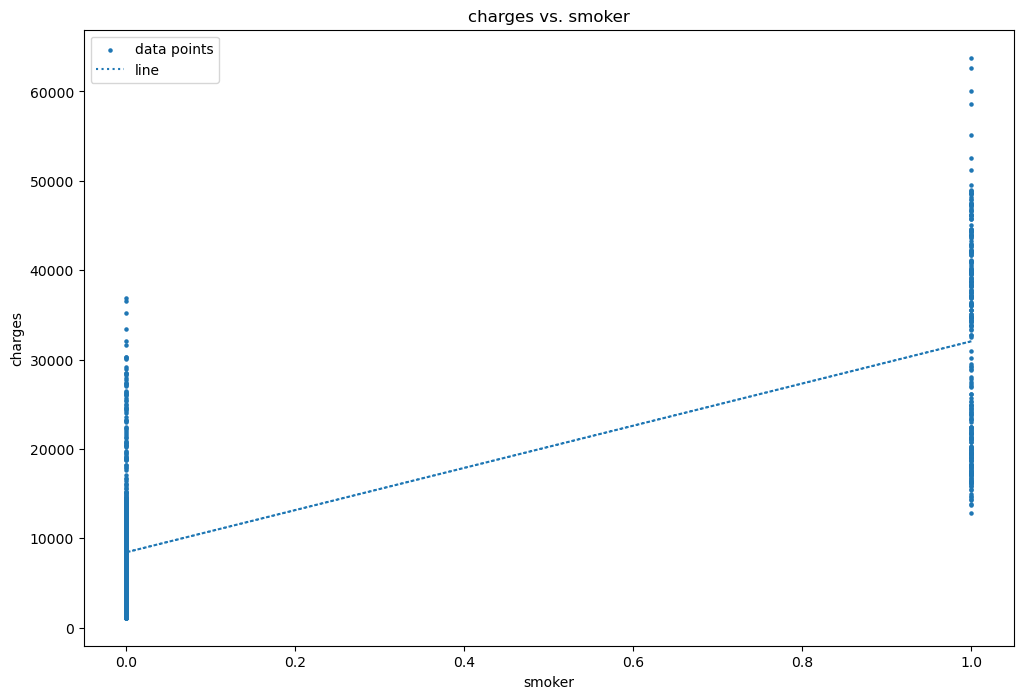

In [163]:
# Fit a linear regression model
coefficients = np.polyfit(X['smoker'], y, 1)
trendline = np.poly1d(coefficients)

# Scatter plot
plt.rcParams["figure.figsize"] = (12, 8)
plt.scatter(X['smoker'], y, label="data points", s=5)
plt.plot(X['smoker'], trendline(X['smoker']), linestyle=':', label="line")
plt.xlabel("smoker")
plt.ylabel("charges")
plt.title("charges vs. smoker")
plt.legend()

plt.show()

Smoker is also a dummy variable, and is therefore linear by default.

##### Plotting actual vs. predicted

In [164]:
def calculate_residuals(X_vars, y_var, model = linmod.LinearRegression()):
    """
    Creates predictions on the X_vars with the model (using linear regression by default) and calculates residuals
    """
    results = model.fit(X_vars, y_var)
    predictions = model.predict(X_vars)
    df_results = pd.DataFrame({'Actual': y_var, 'Predicted': predictions})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    
    return df_results

In [198]:
def linear_assumption(X_vars, y_var, model = linmod.LinearRegression()):
    """
    Linearity: Assumes that there is a linear relationship between the predictors and
               the response variable. If not, either a quadratic term or another
               algorithm should be used.
    """
    print('Assumption 1: Linear Relationship between the Target and the Feature', '\n')
        
    print('Checking with a scatter plot of actual vs. predicted.',
           'Predictions should follow the diagonal line.')
    
    # Calculating residuals for the plot
    df_results = calculate_residuals(X_vars, y_var, model)
    
    # Plotting the actual vs predicted values
    sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False, scatter_kws={"s": 1})
        
    # Plotting the diagonal line
    line_coords = np.arange(df_results.min().min(), df_results.max().max())
    plt.plot(line_coords, line_coords,  # X and y points
             color='darkorange', linestyle=':')
    plt.title('Actual vs. Predicted')
    plt.show()

Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


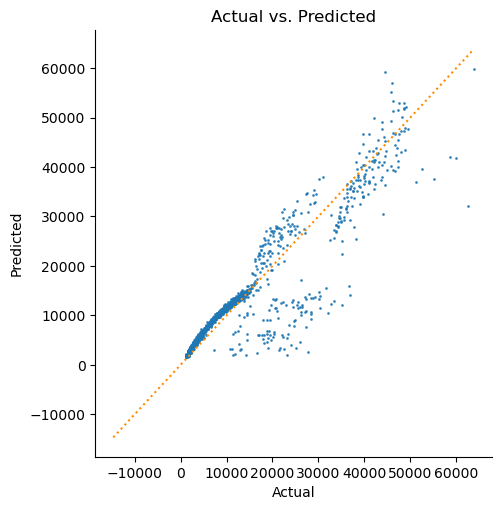

In [199]:
linear_assumption(X, y)

This plot looks somewhat linear, but there are clearly three clusters, which are linear by themselves. In addition, our predictions are biased towards lower values in both the mid section (around 10000-350000) and especially at the higher values (above 50000). I could transform some of the predictors and see if that improves the model, but I suspect that the issue is that additional variables are required to help capture the relationship between the `X_vars` and the `y_var`.

I will assume linearity for now, but I'll check again for linearity once I've added these additional variables to the model (see step 8).


#### OLS Assumption 2: The error term has a population mean of zero
Satisfied by default, since I will include constants in all of my models, which forces the mean of the residuals to equal zero.

#### OLS Assumption 3: All independent variables are uncorrelated with the error term (exogeneity; no endogeneity)
If an independent variable is correlated with the error term, the independent variable can be used to predict the error term, which violates the notion that the error term represents unpredictable random error. We need to find a way to incorporate that information into the regression model itself.

This assumption is also referred to as exogeneity. When this type of correlation exists, there is endogeneity, which biases the coefficient estimates. I will check for endogeneity through residual plots for each independent variable. If the residuals are randomly scattered around the red zero line, it suggests that the assumption is met for that predictor.

In [194]:
def exogeneity_assumption(X_vars, y_var, model=linmod.LinearRegression()):
    df_results = calculate_residuals(X_vars, y_var, model)
    for column in X_vars.columns[1:]:
        plt.figure(figsize=(8, 4))
        plt.scatter(X_vars[column], df_results.Residuals, s=5, alpha=0.5)
        plt.axhline(y=0, color='r', linestyle=':')
        plt.xlabel(column)
        plt.ylabel('Residuals')
        plt.title(f'Residual Plot for {column}')
        plt.show()

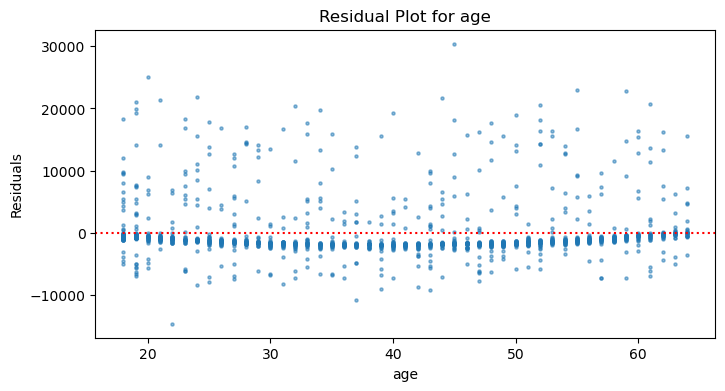

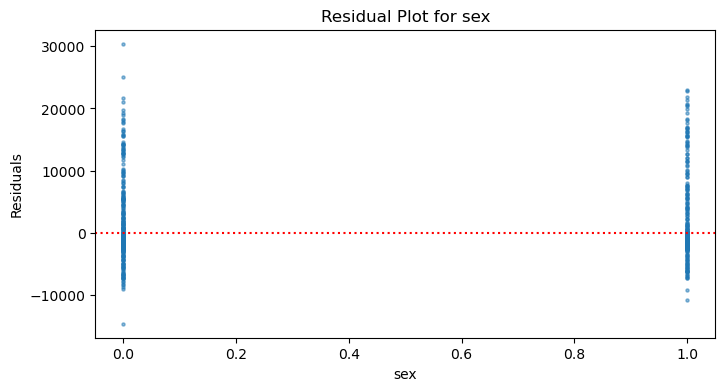

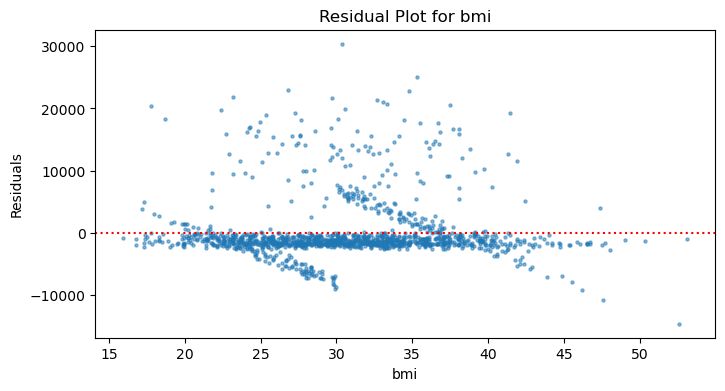

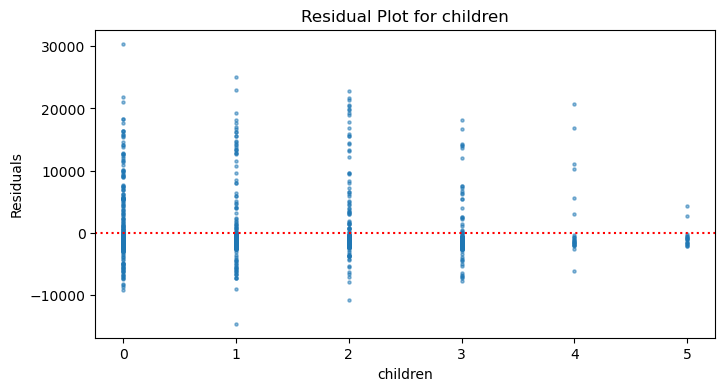

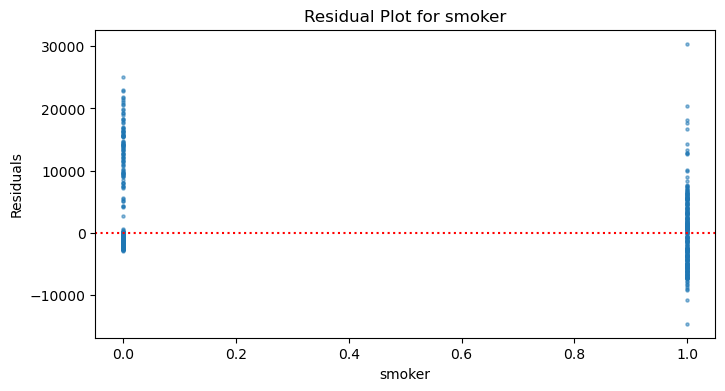

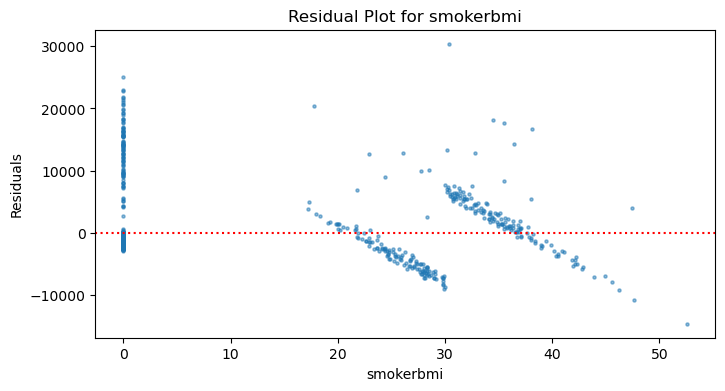

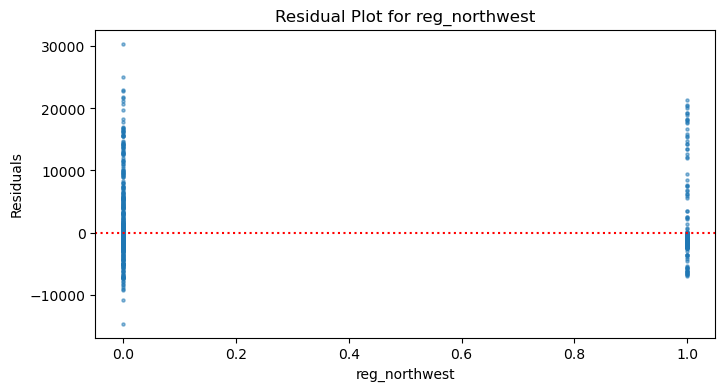

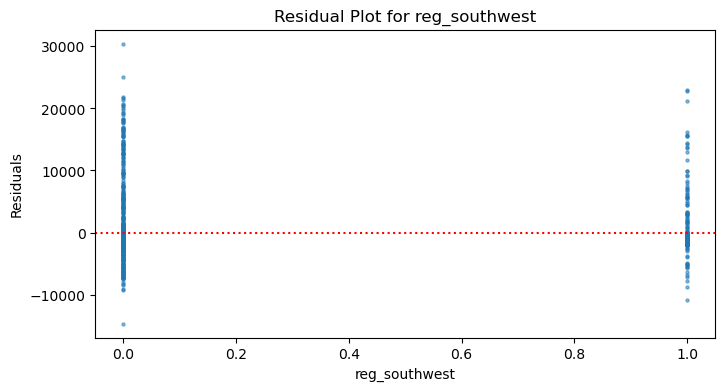

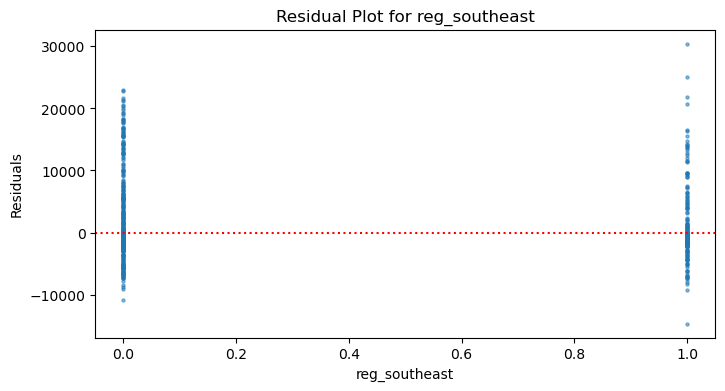

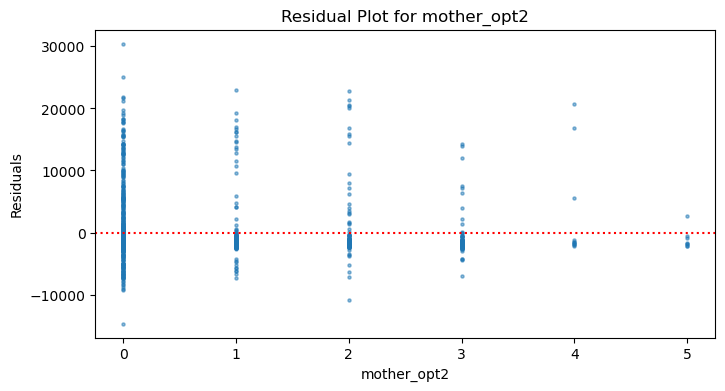

In [197]:
exogeneity_assumption(X, y)

#### OLS Assumption 4: Observations of the error term are uncorrelated with each other (no autocorrelation)
I will check for autocorrelation using the Durbin-Watson (DW) test. A general rule to follow is: DW test statistic values in the range of 1.5 to 2.5 are relatively acceptable. Values outside of this range could be a cause for worry. Values under 1 or more than 3 are a definite cause for worry.

The initial OLS regression summary already includes a DW statistic, which is 2.087. That's an ideal score: I've found no evidence of autocorrelation.

#### OLS Assumption 5: The error term has a constant variance (homoscedasticity; no heteroscedasticity)

In [201]:
def homoscedasticity_assumption(X_vars, y_var, model=linmod.LinearRegression()):
    """
    Homoscedasticity: Assumes that the errors exhibit constant variance
    """
    print('Assumption 5: Homoscedasticity of Error Terms', '\n')
    
    print('Residuals should have relative constant variance')
        
    # Calculating residuals for the plot
    df_results = calculate_residuals(X_vars, y_var, model)

    # Plotting the residuals
    plt.subplots(figsize=(12, 6))
    ax = plt.subplot(111)  # To remove spines
    plt.scatter(x=df_results.index, y=df_results.Residuals, s=5, alpha=0.5)
    plt.plot(np.repeat(0, df_results.index.max()), color='darkorange', linestyle=':')
    ax.spines['right'].set_visible(False)  # Removing the right spine
    ax.spines['top'].set_visible(False)  # Removing the top spine
    plt.title('Residuals')
    plt.show()

Assumption 5: Homoscedasticity of Error Terms 

Residuals should have relative constant variance


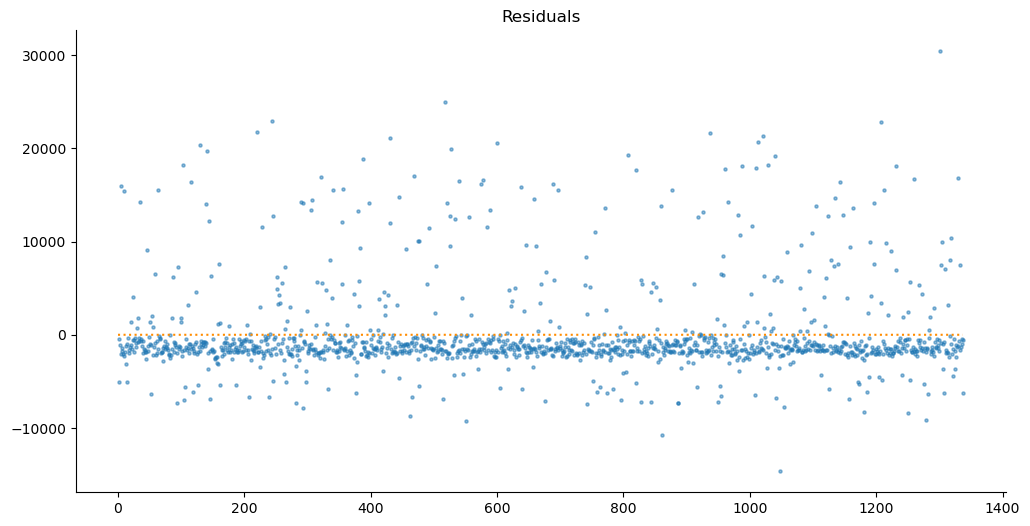

In [202]:
homoscedasticity_assumption(X, y)

There don't seem to be any heteroscedasticity issues.

#### OLS Assumption 6: No independent variable is a perfect linear function of other explanatory variables (no perfect multicollinearity)
This assumes that the predictors used in the regression are not correlated with each other. This won’t render our model unusable if violated, but it will cause issues with the interpretability of the model.

Multicollinearity causes issues with the interpretation of the coefficients. Additionally, it increases the standard error of the coefficients, which results in them potentially showing as statistically insignificant when they might actually be significant.

I will use a heatmap of the correlation as a visual aid and examine the variance inflation factor (VIF). If there are issues, I will either remove predictors with a high variance inflation factor (VIF) or perform dimensionality reduction.


In [171]:
def multicollinearity_assumption(X_vars, y_var, model=linmod.LinearRegression(), feature_names=None):
    """
    Multicollinearity: Assumes that predictors are not correlated with each other. If there is
                       correlation among the predictors, then either remove prepdictors with high
                       Variance Inflation Factor (VIF) values or perform dimensionality reduction
                           
                       This assumption being violated causes issues with interpretability of the 
                       coefficients and the standard errors of the coefficients.
    """
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    print('Assumption 3: Little to no multicollinearity among predictors')
        
    # Plotting the heatmap
    plt.figure(figsize = (10,8))
    sns.heatmap(pd.DataFrame(X_vars).corr(), annot=True)
    plt.title('Correlation of Variables')
    plt.show()
        
    print('Variance Inflation Factors (VIF)')
    print('> 10: An indication that multicollinearity may be present')
    print('> 100: Certain multicollinearity among the variables')
    print('-------------------------------------')
       
    # Gathering the VIF for each variable
    VIF = [variance_inflation_factor(X_vars, i) for i in range(X_vars.shape[1])]
    for idx, vif in enumerate(VIF):
        print('{0}: {1}'.format(feature_names[idx], vif))
        
    # Gathering and printing total cases of possible or definite multicollinearity
    possible_multicollinearity = sum([1 for vif in VIF if vif > 10])
    definite_multicollinearity = sum([1 for vif in VIF if vif > 100])
    print()
    print('{0} cases of possible multicollinearity'.format(possible_multicollinearity))
    print('{0} cases of definite multicollinearity'.format(definite_multicollinearity))
    print()

    if definite_multicollinearity == 0:
        if possible_multicollinearity == 0:
            print('Assumption satisfied')
        else:
            print('Assumption possibly satisfied')
            print()
            print('Coefficient interpretability may be problematic')
            print('Consider removing variables with a high Variance Inflation Factor (VIF)')

    else:
        print('Assumption not satisfied')
        print()
        print('Coefficient interpretability will be problematic')
        print('Consider removing variables with a high Variance Inflation Factor (VIF)')

Assumption 3: Little to no multicollinearity among predictors


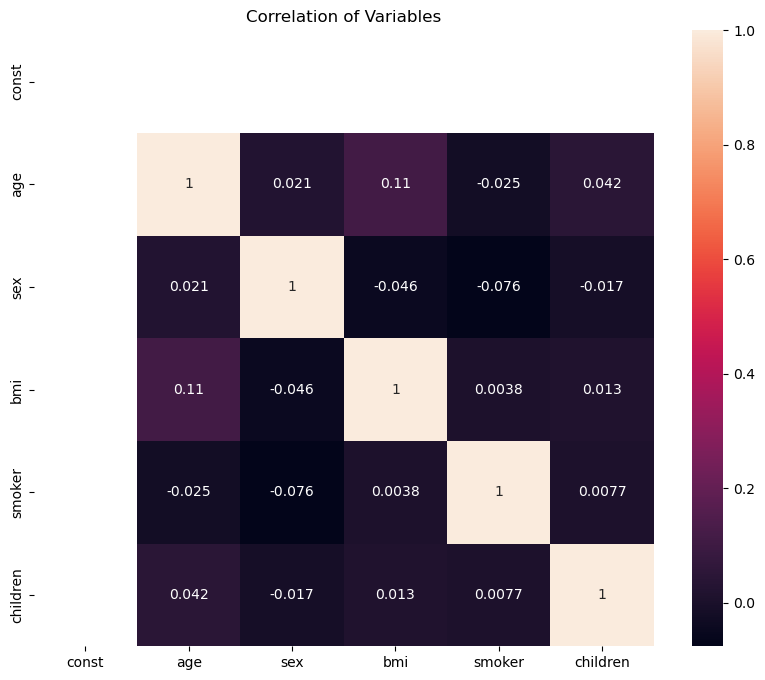

Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------
const: 33.742995811388575
age: 1.0151285547348963
sex: 1.0088783860582888
bmi: 1.01457779347677
smoker: 1.0064568332917263
children: 1.00224205553297

1 cases of possible multicollinearity
0 cases of definite multicollinearity

Assumption possibly satisfied

Coefficient interpretability may be problematic
Consider removing variables with a high Variance Inflation Factor (VIF)


In [172]:
multicollinearity_assumption(X, y, feature_names=final_feature_names)

Multicollinearity in the `const` is not relevant, as the constant is only in the model because it has to be. The constant is not an effect that is directly of interest to my research question. All the other variables are fine, so I do not find a multicollinearity problem.

#### OLS Assumption 7: The error term is normally distributed (optional)
OLS does not require a normal distribution of the error term for estimators to be BLUE (Best Linear Unbiased Estimator), but satisfying this 7th assumption allows for statistical hypothesis testing with reliable confidence intervals and prediction intervals.

In [173]:
def normal_errors_assumption(X_vars, y_var, model=linmod.LinearRegression(), p_value_thresh=0.05):
    """
    Normality: Assumes that the error terms are normally distributed. If they are not,
    nonlinear transformations of variables may solve this.
               
    This assumption being violated primarily causes issues with the confidence intervals.
    """
    from statsmodels.stats.diagnostic import normal_ad
    print('Assumption 2: The error terms are normally distributed', '\n')

    # Suppress warnings
    import warnings
    warnings.filterwarnings("ignore", "use_inf_as_na")
    
    # Calculating residuals for the Anderson-Darling test
    df_results = calculate_residuals(X_vars, y_var, model)
    
    # Replace inf values with NaN
    df_results.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    print('Using the Anderson-Darling test for normal distribution')

    # Performing the test on the residuals
    p_value = normal_ad(df_results['Residuals'].dropna())[1]
    print('p-value from the test - below 0.05 generally means non-normal:', p_value)
    
    # Reporting the normality of the residuals
    if p_value < p_value_thresh:
        print('Residuals are not normally distributed')
    else:
        print('Residuals are normally distributed')
    
    # Plotting the residuals distribution
    plt.subplots(figsize=(12, 6))
    plt.title('Distribution of residuals')
    sns.histplot(df_results['Residuals'], kde=True)
    plt.show()
    
    print()
    if p_value > p_value_thresh:
        print('Assumption satisfied')
    else:
        print('Assumption not satisfied')
        print()
        print('Confidence intervals will likely be affected')
        print('Try performing nonlinear transformations on variables')

Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.0
Residuals are not normally distributed


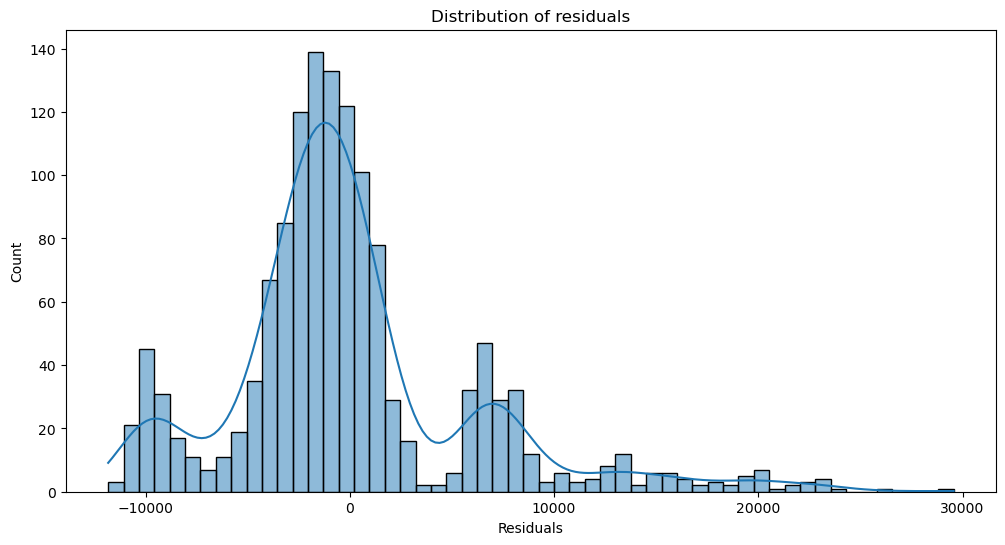


Assumption not satisfied

Confidence intervals will likely be affected
Try performing nonlinear transformations on variables


In [174]:
normal_errors_assumption(X, y)

### Step 5: add the smokerbmi interaction effect
Since I found two very different slopes in the charges-bmi relationship for smokers vs. non-smokers, I suspect that there may be an interaction effect. Not only do smokers have higher `charges` than non-smokers, which is unsurprising, but the *slope* of the charges-bmi relationship is much steeper. That suggests that gaining wait doesn't really increase `charges` if you don't smoke, but it does if you do smoke.

##### Code

In [175]:
y = df['charges']
X = df[['const', 'age', 'sex', 'bmi', 'children', 'smoker', 'smokerbmi']]
model = ols(y, exog=X, missing='raise')
results_smokerbmi = model.fit()

##### Results

In [176]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     798.0
Date:                Sun, 05 May 2024   Prob (F-statistic):               0.00
Time:                        19:01:09   Log-Likelihood:                -13551.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1332   BIC:                         2.715e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.218e+04    963.902    -12.637      0.000   -1.41e+04   -1.03e+04
age          257.7350     11.904     21.651      0.000     234.383     281.087
sex          128.6399    333.361      0.386      0.700    -525.329     782.609
bmi          322.3642     27.419     11.757      0.000     268.576     376.153
smoker      2.382e+04    412.523     57.750      0.000     2.3e+04    2.46e+04
children     474.4111    137.856      3.441      0.001     203.973     744.849
==============================================================================
Omnibus:                      301.103   Durbin-Watson:                   2.087
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              720.380
Skew:                           1.214   Prob(JB):                    3.73e-157
Kurtosis:                       5.650   Cond. No.                         299.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [177]:
results_smokerbmi.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     1158.
Date:                Sun, 05 May 2024   Prob (F-statistic):               0.00
Time:                        19:01:09   Log-Likelihood:                -13255.
No. Observations:                1338   AIC:                         2.652e+04
Df Residuals:                    1331   BIC:                         2.656e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2998.4982    843.173     -3.556      0.000   -4652.590   -1344.406
age          264.5310      9.547     27.709      0.000     245.802     283.260
sex          495.4575    267.603      1.851      0.064     -29.511    1020.426
bmi            6.5451     24.855      0.263      0.792     -42.214      55.304
children     512.5458    110.531      4.637      0.000     295.711     729.380
smoker      -2.03e+04   1653.971    -12.273      0.000   -2.35e+04   -1.71e+04
smokerbmi   1438.7131     52.842     27.227      0.000    1335.051    1542.375
==============================================================================
Omnibus:                      718.596   Durbin-Watson:                   2.073
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4381.674
Skew:                           2.522   Prob(JB):                         0.00
Kurtosis:                      10.290   Cond. No.                         660.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

`smokerbmi` is highly significant, and adding it to the model improved the adj. R-sq from 0.749 to 0.839. Interestingly, the initial model that didn't include `smokerbmi` had a positive and very large coefficient for `smoker`. In this extended model, `smoker` is still significant, but now has a negative coefficient. 

This makes sense because in this extended model, `smoker` is 0 and `smokerbmi` is also 0 for non-smokers. For smokers, however, `smoker` is 1 and `smokerbmi` equals their `bmi`, which is a much higher number than 0 or 1. Whereas in the initial model, the coefficient of `smoker` was multiplied by 1 for smokers, adding to their estimated `charges`, this extended model includes another coefficient, for the interaction variable `smokerbmi`, which is multiplied by `bmi`, also adding to the estimate of`charges`. The now negative coefficient for `smoker` compensates for this additional predictor.

Additionally, `bmi` is no longer significant. This shows that any effect that `bmi` appeared to have in the initial regression, is actually an effect of being a smoker *and* having a high `bmi`. I will continue to include `bmi` in the model because that is required by the use of interaction variable `smokerbmi`.

Finally, `sex` is now much more statistically significant than it was in the initial model (from 0.7 to 0.064). That makes it still not statistically significant at p < 0.05, but the change is notable. Perhaps it will become significant if the mother effect is added.

### Step 6: add dummies for 'region'
Having converted 'region' into four dummy variables, I'll include them into the OLS regression to see whether they add any value to the model. Note that I'm avoiding the dummy variable trap by adding only three dummy variables, given that there are four regions.

##### Code

In [178]:
y = df['charges']
X = df[['const', 'age', 'sex', 'bmi', 'children', 'smoker', 'smokerbmi', 'reg_northwest', 'reg_southwest', 'reg_southeast']]
model = ols(y, exog=X, missing='raise')
results_regions = model.fit()

##### Results

In [179]:
results_smokerbmi.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     1158.
Date:                Sun, 05 May 2024   Prob (F-statistic):               0.00
Time:                        19:01:09   Log-Likelihood:                -13255.
No. Observations:                1338   AIC:                         2.652e+04
Df Residuals:                    1331   BIC:                         2.656e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2998.4982    843.173     -3.556      0.000   -4652.590   -1344.406
age          264.5310      9.547     27.709      0.000     245.802     283.260
sex          495.4575    267.603      1.851      0.064     -29.511    1020.426
bmi            6.5451     24.855      0.263      0.792     -42.214      55.304
children     512.5458    110.531      4.637      0.000     295.711     729.380
smoker      -2.03e+04   1653.971    -12.273      0.000   -2.35e+04   -1.71e+04
smokerbmi   1438.7131     52.842     27.227      0.000    1335.051    1542.375
==============================================================================
Omnibus:                      718.596   Durbin-Watson:                   2.073
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4381.674
Skew:                           2.522   Prob(JB):                         0.00
Kurtosis:                      10.290   Cond. No.                         660.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [180]:
results_regions.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     780.0
Date:                Sun, 05 May 2024   Prob (F-statistic):               0.00
Time:                        19:01:09   Log-Likelihood:                -13248.
No. Observations:                1338   AIC:                         2.652e+04
Df Residuals:                    1328   BIC:                         2.657e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2723.5999    868.881     -3.135      0.002   -4428.128   -1019.072
age             263.6202      9.516     27.703      0.000     244.952     282.288
sex             500.1460    266.518      1.877      0.061     -22.695    1022.987
bmi              23.5329     25.601      0.919      0.358     -26.689      73.755
children        516.4034    110.179      4.687      0.000     300.259     732.548
smoker        -2.042e+04   1648.277    -12.386      0.000   -2.36e+04   -1.72e+04
smokerbmi      1443.0964     52.647     27.411      0.000    1339.816    1546.377
reg_northwest  -585.4780    380.859     -1.537      0.124   -1332.630     161.674
reg_southwest -1231.1077    382.218     -3.221      0.001   -1980.924    -481.291
reg_southeast -1210.1312    382.750     -3.162      0.002   -1960.992    -459.270
==============================================================================
Omnibus:                      721.596   Durbin-Watson:                   2.069
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4465.236
Skew:                           2.529   Prob(JB):                         0.00
Kurtosis:                      10.384   Cond. No.                         662.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Including regions didn't improve the adj. R-sq very much, but two of the three dummy variabels for regions show statistical significance. Ignoring the insignificance of `reg_northwest` for a moment, all three coefficients for the regions are negative, implying that the reference region 'northeast' has the highest `charges`. Since there indeed are some regional effects, I will continue to include all three dummies in the model.

Notably, `bmi`'s p-value has improved, although it's still far from significant.

### Step 7: add the mother effect
Let's now create an interaction variable using `sex` and `children` to see whether being a mother actually explains any effect that we've so far ascribed to `sex` or `children`.

#### Option 1 (`mother_opt1 = 1` for women with 1 or more children; else `mother_opt1 = 0`)
There are two ways to go about this. The first is to create an interaction variable which will itself also be a dummy, and then add that to the model as an independent variable (leaving its components `sex` and `children` in as well).

##### Code

In [181]:
y = df['charges']
X = df[['const', 'age', 'sex', 'bmi', 'children', 'smoker', 'smokerbmi', 'reg_northwest', 'reg_southwest', 'reg_southeast', 'mother_opt1']]
model = ols(y, exog=X, missing='raise')
results_moth1 = model.fit()

##### Result

In [182]:
results_moth1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     702.3
Date:                Sun, 05 May 2024   Prob (F-statistic):               0.00
Time:                        19:01:09   Log-Likelihood:                -13247.
No. Observations:                1338   AIC:                         2.652e+04
Df Residuals:                    1327   BIC:                         2.657e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2623.1684    873.276     -3.004      0.003   -4336.320    -910.017
age             263.2584      9.520     27.653      0.000     244.582     281.935
sex             206.1033    371.567      0.555      0.579    -522.820     935.027
bmi              23.6346     25.598      0.923      0.356     -26.582      73.851
children        433.7027    132.062      3.284      0.001     174.629     692.776
smoker        -2.045e+04   1648.374    -12.406      0.000   -2.37e+04   -1.72e+04
smokerbmi      1444.4973     52.656     27.433      0.000    1341.200    1547.795
reg_northwest  -579.1805    380.858     -1.521      0.129   -1326.331     167.969
reg_southwest -1229.2370    382.180     -3.216      0.001   -1978.979    -479.495
reg_southeast -1215.5919    382.739     -3.176      0.002   -1966.431    -464.753
mother_opt1     517.9014    456.062      1.136      0.256    -376.780    1412.583
==============================================================================
Omnibus:                      717.858   Durbin-Watson:                   2.070
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4399.826
Skew:                           2.516   Prob(JB):                         0.00
Kurtosis:                      10.321   Cond. No.                         662.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Option 2 (`mother_opt2 = sex * children`)
The second way is to create an interaction variable by multiplying `sex` by `children`, which will always be `0` for men and for women with no children, but for women with children, `mother_opt2` will be equal to their number of children. That variable is then added to the model as an independent variable (leaving its components `sex` and `children` in as well).

##### Code

In [183]:
y = df['charges']
X = df[['const', 'age', 'sex', 'bmi', 'children', 'smoker', 'smokerbmi', 'reg_northwest', 'reg_southwest', 'reg_southeast', 'mother_opt2']]
model = ols(y, exog=X, missing='raise')
results_moth2 = model.fit()

##### Result

In [184]:
results_moth2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     702.2
Date:                Sun, 05 May 2024   Prob (F-statistic):               0.00
Time:                        19:01:09   Log-Likelihood:                -13247.
No. Observations:                1338   AIC:                         2.652e+04
Df Residuals:                    1327   BIC:                         2.657e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2561.7760    881.226     -2.907      0.004   -4290.524    -833.028
age             263.2721      9.520     27.653      0.000     244.595     281.949
sex             236.7076    358.594      0.660      0.509    -466.765     940.181
bmi              22.9456     25.604      0.896      0.370     -27.283      73.175
children        399.5377    153.189      2.608      0.009      99.018     700.057
smoker        -2.048e+04   1649.214    -12.418      0.000   -2.37e+04   -1.72e+04
smokerbmi      1445.5631     52.691     27.435      0.000    1342.197    1548.930
reg_northwest  -586.9787    380.832     -1.541      0.123   -1334.078     160.121
reg_southwest -1234.1145    382.198     -3.229      0.001   -1983.893    -484.336
reg_southeast -1216.0325    382.758     -3.177      0.002   -1966.910    -465.155
mother_opt2     242.0836    220.486      1.098      0.272    -190.455     674.623
==============================================================================
Omnibus:                      720.204   Durbin-Watson:                   2.068
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4435.659
Skew:                           2.525   Prob(JB):                         0.00
Kurtosis:                      10.353   Cond. No.                         663.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Neither of these two options show a significant result, nor has the adj. R-sq of the model improved. Both options also made `sex` less significant than before. I therefore have no good reason to assume that being a mother has any effect on `charges` that is separate from the effects of being a parent or being a woman, so I will not include it in my final model going forward.

### Step 8: the final model

##### Code

In [185]:
y_final = df['charges']
X_final = df[['const', 'age', 'sex', 'bmi', 'children', 'smoker', 'smokerbmi', 'reg_northwest', 'reg_southwest', 'reg_southeast']]
model = ols(y, exog=X, missing='raise')
results_final = model.fit()
final_feature_names = [X_final.keys()[i] for i in range(len(X_final.keys()))]

##### Results

In [186]:
results_final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     702.2
Date:                Sun, 05 May 2024   Prob (F-statistic):               0.00
Time:                        19:01:10   Log-Likelihood:                -13247.
No. Observations:                1338   AIC:                         2.652e+04
Df Residuals:                    1327   BIC:                         2.657e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2561.7760    881.226     -2.907      0.004   -4290.524    -833.028
age             263.2721      9.520     27.653      0.000     244.595     281.949
sex             236.7076    358.594      0.660      0.509    -466.765     940.181
bmi              22.9456     25.604      0.896      0.370     -27.283      73.175
children        399.5377    153.189      2.608      0.009      99.018     700.057
smoker        -2.048e+04   1649.214    -12.418      0.000   -2.37e+04   -1.72e+04
smokerbmi      1445.5631     52.691     27.435      0.000    1342.197    1548.930
reg_northwest  -586.9787    380.832     -1.541      0.123   -1334.078     160.121
reg_southwest -1234.1145    382.198     -3.229      0.001   -1983.893    -484.336
reg_southeast -1216.0325    382.758     -3.177      0.002   -1966.910    -465.155
mother_opt2     242.0836    220.486      1.098      0.272    -190.455     674.623
==============================================================================
Omnibus:                      720.204   Durbin-Watson:                   2.068
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4435.659
Skew:                           2.525   Prob(JB):                         0.00
Kurtosis:                      10.353   Cond. No.                         663.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### OLS Assumption 1: The regression model is linear in the coefficients and the error term
I will first use scatter plots to visually inspect the linearity of the relationship between the dependent variable and each independent variable. I will then use a function that first calculates the residuals, and then creates a scatter plot of actual vs. predicted values. If I see a relatively even spread around the diagonal line, I will consider this assumption verified.

Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


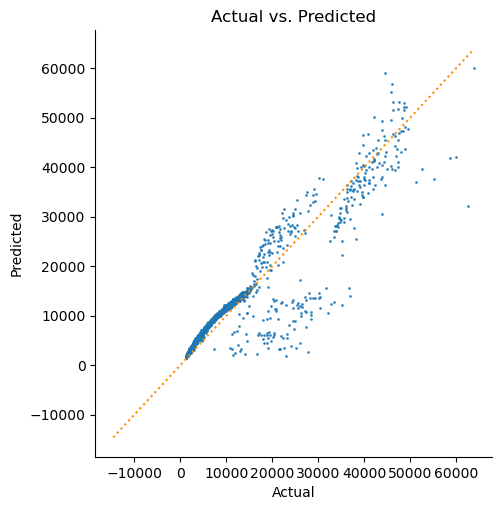

In [200]:
linear_assumption(df[['const', 'age', 'sex', 'bmi', 'children', 'smoker', 'smokerbmi', 'reg_northwest', 'reg_southwest', 'reg_southeast']], y_final)

This plot is slightly different, but very similar to the plot resulting from the initial models. Potential issues relating to non-linearity of some variables persist.

#### OLS Assumption 2: The error term has a population mean of zero
Satisfied by default, since this model includes constant, which forces the mean of the residuals to equal zero.

#### OLS Assumption 3: All independent variables are uncorrelated with the error term (exogeneity; no endogeneity)
If an independent variable is correlated with the error term, the independent variable can be used to predict the error term, which violates the notion that the error term represents unpredictable random error. We need to find a way to incorporate that information into the regression model itself.

This assumption is also referred to as exogeneity. When this type of correlation exists, there is endogeneity, which biases the coefficient estimates. I will check for endogeneity through residual plots for each independent variable. If the residuals are randomly scattered around the red zero line, it suggests that the assumption is met for that predictor.

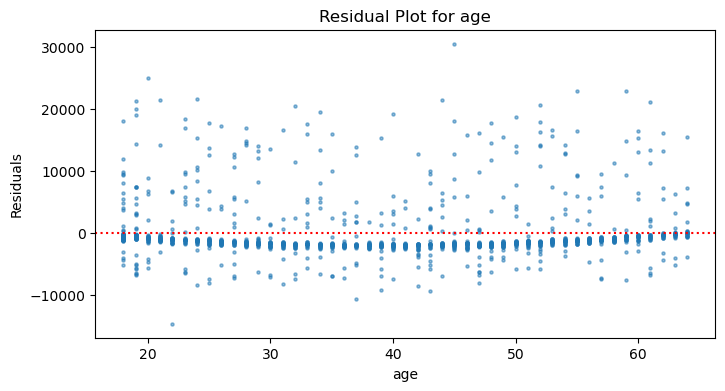

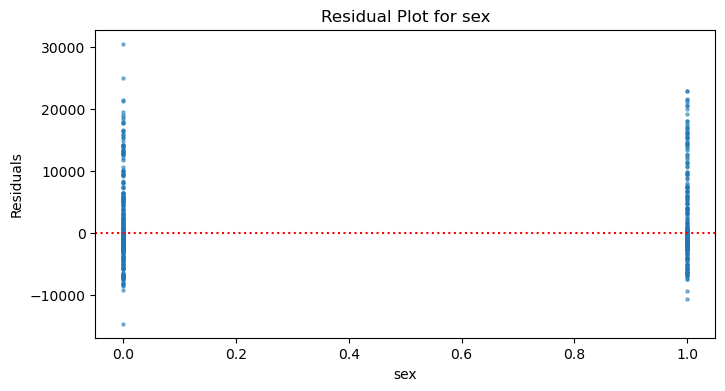

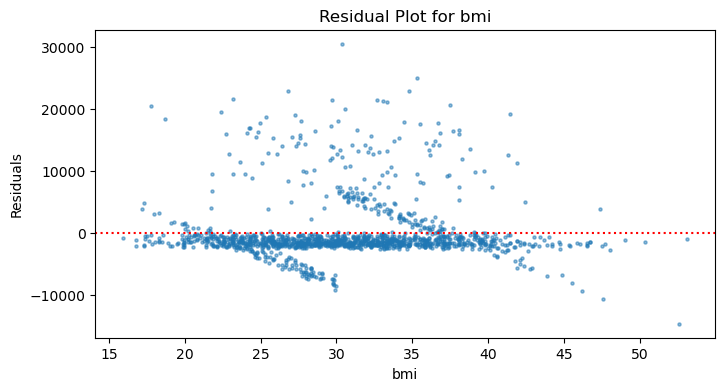

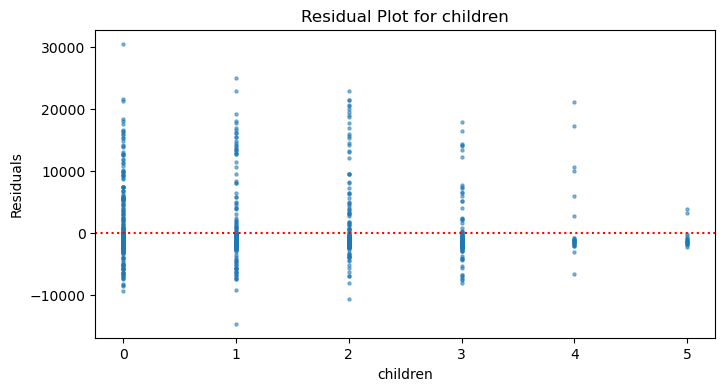

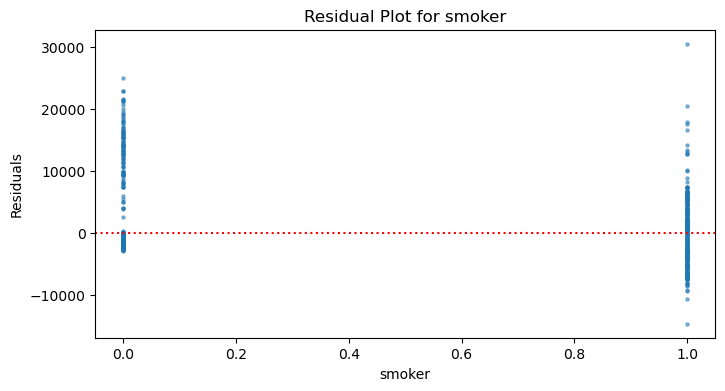

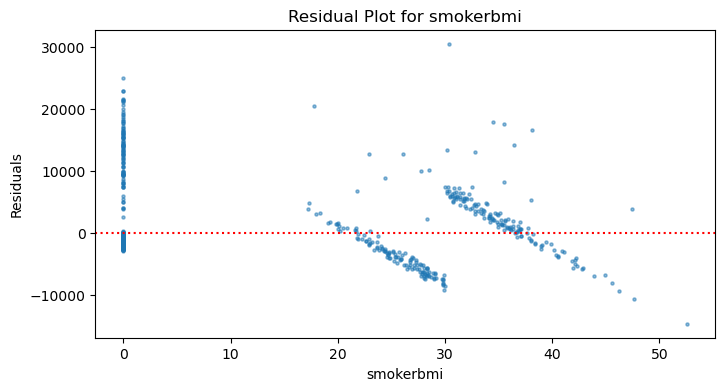

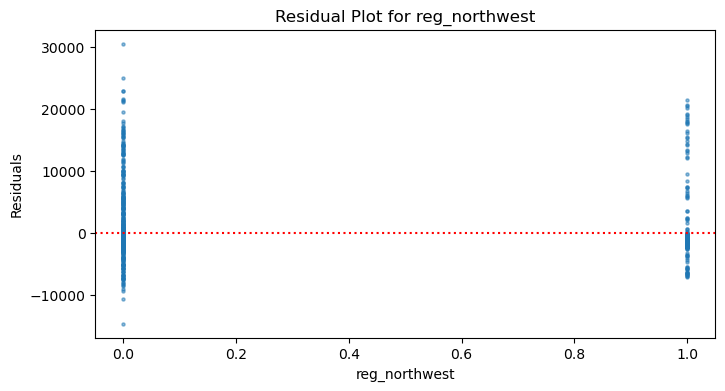

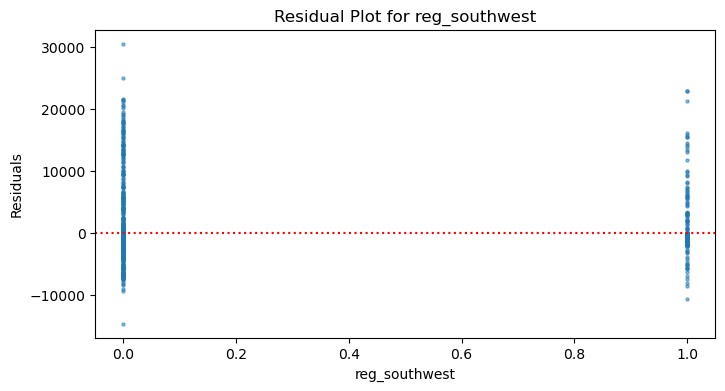

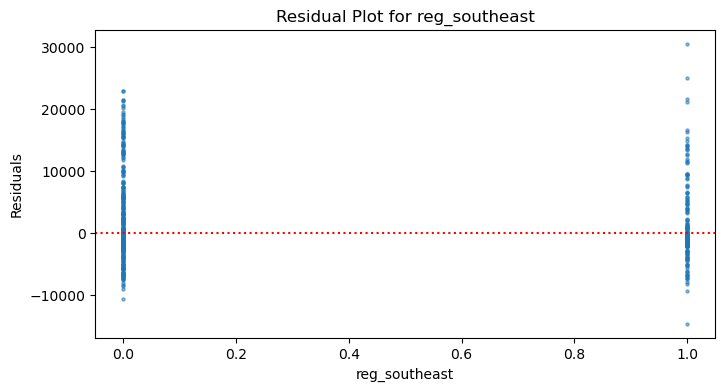

In [196]:
exogeneity_assumption(X_final, y_final)

`age` is almost linear, but clearly shows slight curvature, so it isn't completely uncorrelated with the error term. 

`bmi` also clearly shows two clusters of diagonal lines, intersecting with a cluster of a horizontal line (that sits a bit under the dashed 0 line). Although `smoker` is a dummy variable, which makes it a bit difficult to tell, it also doesn't seem to fit a horizontal line. As a result, `smokerbmi` has a combination of the issues that `bmi` and `smoker` have.

Transformation of these variables will not fix this, nor are there any more independent variables available to add. I also didn't find any other meaningful interaction between variables. I will accept the fact that this assumption wasn't met as a limitation of my model.

#### OLS Assumption 4: Observations of the error term are uncorrelated with each other (no autocorrelation, i.e. no serial correlation)
I will check for autocorrelation using the Durbin-Watson (DW) test. A general rule to follow is: DW test statistic values in the range of 1.5 to 2.5 are relatively acceptable. Values outside of this range could be a cause for worry. Values under 1 or more than 3 are a definite cause for worry.

The final OLS regression summary already includes a DW statistic, which is 2.068. That's an ideal score: I've found no evidence of autocorrelation.

#### OLS Assumption 5: The error term has a constant variance (homoscedasticity; no heteroscedasticity)

Assumption 5: Homoscedasticity of Error Terms 

Residuals should have relative constant variance


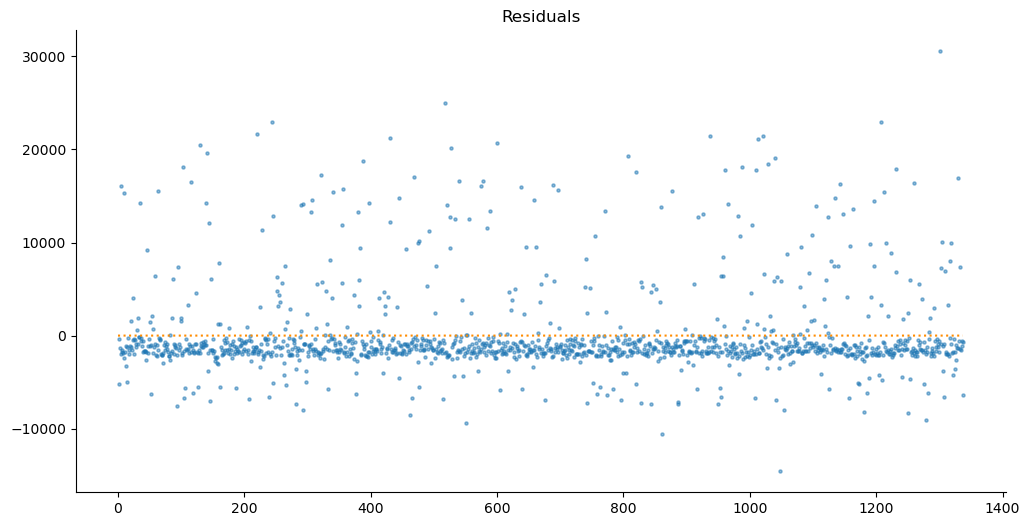

In [203]:
homoscedasticity_assumption(X_final, y_final)

There don't seem to be any heteroscedasticity issues.

#### OLS Assumption 6: No independent variable is a perfect linear function of other explanatory variables (no perfect multicollinearity)
This assumes that the predictors used in the regression are not correlated with each other. This won’t render our model unusable if violated, but it will cause issues with the interpretability of the model.

Multicollinearity causes issues with the interpretation of the coefficients. Additionally, it increases the standard error of the coefficients, which results in them potentially showing as statistically insignificant when they might actually be significant.

I will use a heatmap of the correlation as a visual aid and examine the variance inflation factor (VIF). If there are issues, I will either remove predictors with a high variance inflation factor (VIF) or perform dimensionality reduction.


Assumption 3: Little to no multicollinearity among predictors


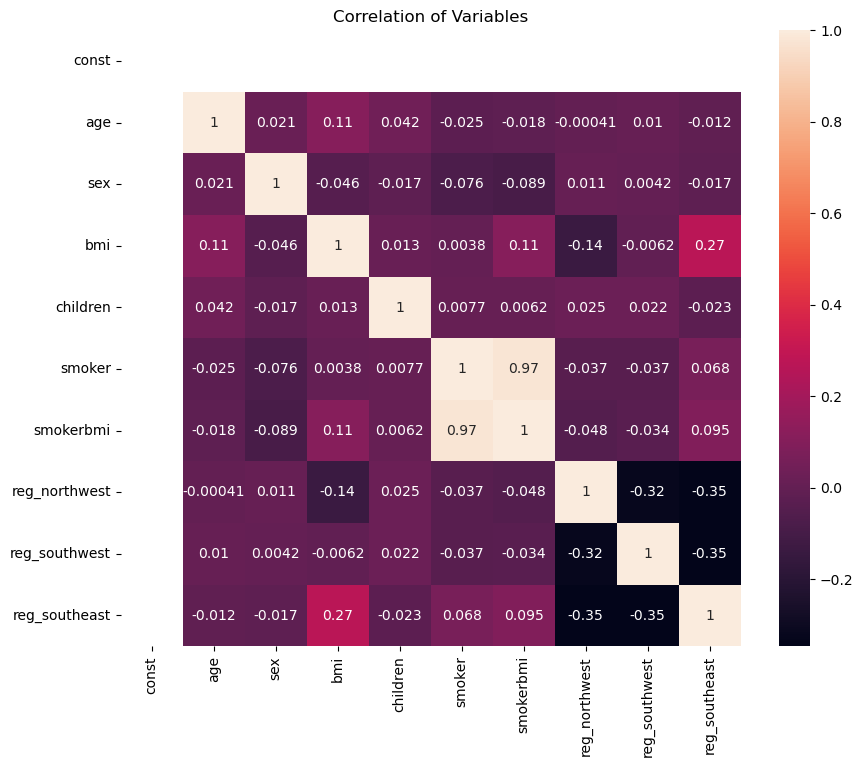

Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------
const: 43.00637129417426
age: 1.017506353343623
sex: 1.011478369862725
bmi: 1.3873583508735299
children: 1.0041948384767976
smoker: 25.203045267398615
smokerbmi: 25.533081228503352
reg_northwest: 1.519576829036112
reg_southwest: 1.5304355573316852
reg_southeast: 1.6526901046924194

3 cases of possible multicollinearity
0 cases of definite multicollinearity

Assumption possibly satisfied

Coefficient interpretability may be problematic
Consider removing variables with a high Variance Inflation Factor (VIF)


In [190]:
multicollinearity_assumption(X_final, y_final, feature_names=final_feature_names)

Only three variables show signs of possible multicollinearity. Multicollinearity increases the standard errors of the estimated coefficients, but it does not bias the coefficient estimates; it just decreases efficiency. Multicollinearity in the `const` is not relevant, as the constant is only in the model because it has to be. The constant is not an effect that is directly of interest to my research question.

The same goes for `smoker` and `smokerbmi`. They are just control variables, and their confidence intervals are sufficiently narrow for the purpose of this research. Furthermore, they are (part of) an interaction variable, so multicollinearity is to be expected and not a cause for concern.

There may be some multicollinearity, but I do not find a multicollinearity problem.

#### OLS Assumption 7: The error term is normally distributed (optional)
OLS does not require a normal distribution of the error term for estimators to be BLUE (Best Linear Unbiased Estimator), but satisfying this 7th assumption allows for statistical hypothesis testing with reliable confidence intervals and prediction intervals.

Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.0
Residuals are not normally distributed


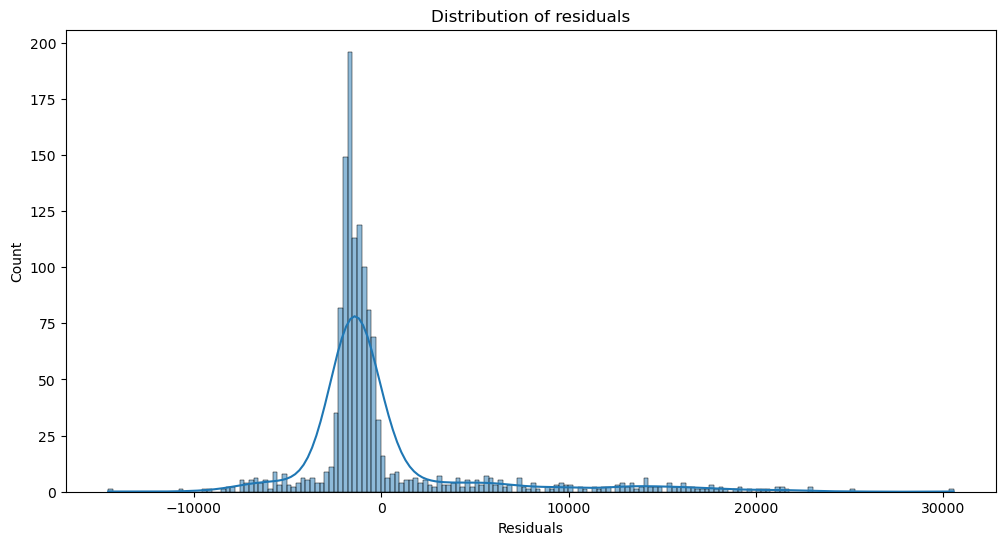


Assumption not satisfied

Confidence intervals will likely be affected
Try performing nonlinear transformations on variables


In [191]:
normal_errors_assumption(df[['const', 'age', 'sex', 'bmi', 'children', 'smoker', 'smokerbmi', 'reg_northwest', 'reg_southwest', 'reg_southeast']], y_final)

This graph shows that the model isn’t ideal, and that it is somewhat biased towards under-estimating. This is not a blocking issue, but a limitation to be noted.


### Step 9: conclusion

Let's take a final look at the regression results.

In [192]:
results_final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     702.2
Date:                Sun, 05 May 2024   Prob (F-statistic):               0.00
Time:                        19:01:13   Log-Likelihood:                -13247.
No. Observations:                1338   AIC:                         2.652e+04
Df Residuals:                    1327   BIC:                         2.657e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2561.7760    881.226     -2.907      0.004   -4290.524    -833.028
age             263.2721      9.520     27.653      0.000     244.595     281.949
sex             236.7076    358.594      0.660      0.509    -466.765     940.181
bmi              22.9456     25.604      0.896      0.370     -27.283      73.175
children        399.5377    153.189      2.608      0.009      99.018     700.057
smoker        -2.048e+04   1649.214    -12.418      0.000   -2.37e+04   -1.72e+04
smokerbmi      1445.5631     52.691     27.435      0.000    1342.197    1548.930
reg_northwest  -586.9787    380.832     -1.541      0.123   -1334.078     160.121
reg_southwest -1234.1145    382.198     -3.229      0.001   -1983.893    -484.336
reg_southeast -1216.0325    382.758     -3.177      0.002   -1966.910    -465.155
mother_opt2     242.0836    220.486      1.098      0.272    -190.455     674.623
==============================================================================
Omnibus:                      720.204   Durbin-Watson:                   2.068
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4435.659
Skew:                           2.525   Prob(JB):                         0.00
Kurtosis:                      10.353   Cond. No.                         663.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Although it should be noted that some limitations to the model were found, particularly some endogeneity issues (i.e. some explanatory variables showed correlation with the error term) and linearity issues, `sex` does not appear to have an effect on `charges`. It is statistically insignificant (p-value of 0.509) and has a very high standard error. Both a positive and a negative effect of `sex` fall within the confidence interval. The model as a whole has an adj. R-squared of 0.840. 

The answer to the question "__does `sex` have an effect on `charges`?__" is therefore **no**.

Interestingly, `bmi` did appear to have an effect on `charges` in and of itself in my initial model, and so did `smoker`. However, after including an interaction variable of the two, it turns out that `bmi` only has an effect on `charges` if the person is also a smoker.